# Helper notebook for *Visualization in Bayesian workflow*

This notebook is to help understand the paper *Visualization in Bayesian workflow*. 

[Open in Colab](https://colab.research.google.com/github/hongsupshin/statisticalrethinking_practice/blob/main/Notebooks/helper_notebook_viz_in_bayesian_workflow.ipynb)

In [ ]:
!pip install -q numpyro arviz causalgraphicalmodels

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, vmap
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

from causalgraphicalmodels import CausalGraphicalModel

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-doc")
numpyro.set_platform("cpu")

from IPython.display import Image

## Overview
- Bayesian analysis
- Toy examples: Globe tossing and Bayesian linear regression
- Basic concepts: DAG, prior, likelihood, and posterior
- Analytic methods from the paper
    - Prior predictive distribution 
    - MCMC diagnostics (PSIS)
    - Posterior predictive distribution
- Quick look of the dataset from the paper

## Brief overview of Bayesian analysis

### Why Bayesian data analysis?
Researchers need more than null hypothesis (it doesn't tell you how your observation is generated)
- You need a scientific causal model -> **Directed Acyclic Graph (DAG)**
- You need a generative model -> **Bayesian data analysis**
    - You can simulate data from the model to design/debug inference -> **generative**
    - You need a strategy to derive estimate and uncertainty
- You need an effective method to do this calculation -> **MCMC and other techniques**

### Is Bayesian overkill?
For simple problems, maybe (like simple linear regression). But it's extremeley useful for typical model problems such as
- Measurement error
- Missing data
- Latent variables
- Regularization

It's also generative!

## Toy example 1: Globe tossing

### Setup
- Question: estimate the proportion (probability) of the globe covered by water ($p$)
- Indirect measurement method: toss the globe and check whether it lands on water or land
- Observations
    - number of total tosses ($N$)
    - number of water observations ($W$)
    - We tossed 9 times and got 6 water observations ($N=9, \ W=6$)
- Model parameters
    - $p$: Probability of water
    - $N$: Total number of observations
    - $W$: Total number of water observations 

### Step 1. Draw a DAG

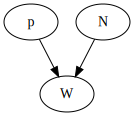

In [2]:
globe_toss = CausalGraphicalModel(
    nodes = ["N", "p", "W"],
    edges = [
        ("N", "W"),
        ("p", "W"),
    ]
)
globe_toss.draw()

### Step 2. Write down the probability of our interest (*posterior*)

We want to estimate the proportion (probability) of the globe covered by water given our observation (=*posterior distribution*):
$$Pr(p|N, W)$$

Time to use Bayes theorem

$$Pr(p|N, W) \propto Pr(p) \times Pr (N, W | p)$$

- $Pr(p)$: prior
- $Pr(N, W| p)$: likelihood
- You can also consider posterior as "updated prior with likelihood"

Generally speaking
- Posterior: $Pr(M|D)$
- Prior: $Pr(M)$
- Likelihood: $Pr(D|M)$

where $M$ is your model (or model parameters), and $D$ is data (or observations)

### Step 3. Define the prior distribution and likelihood *function*

#### Prior, $Pr(p)$

>Probability distribution of $p$ (proportion of water)

Prior is initial plausibility about the model. It's a belief we have when we don't have any observation ($N=0$)). A prior is usually based on our scientific/engineering assumptions. Prior is **a part of the model, which needs to be chosen, evalulated, and revised.**

The *worst* (=most vague) prior is a uniform distribution (=flat prior), which means that we don't know anything about the problem.

For simplicity, let's assume a uniform prior for our problem:
$$p \sim \text{Uniform}(0,\,1)$$

In [3]:
# discretizing the prior space in 20 segments
p_grid = jnp.linspace(start=0, stop=1, num=20)
prior = jnp.repeat(1, 20)

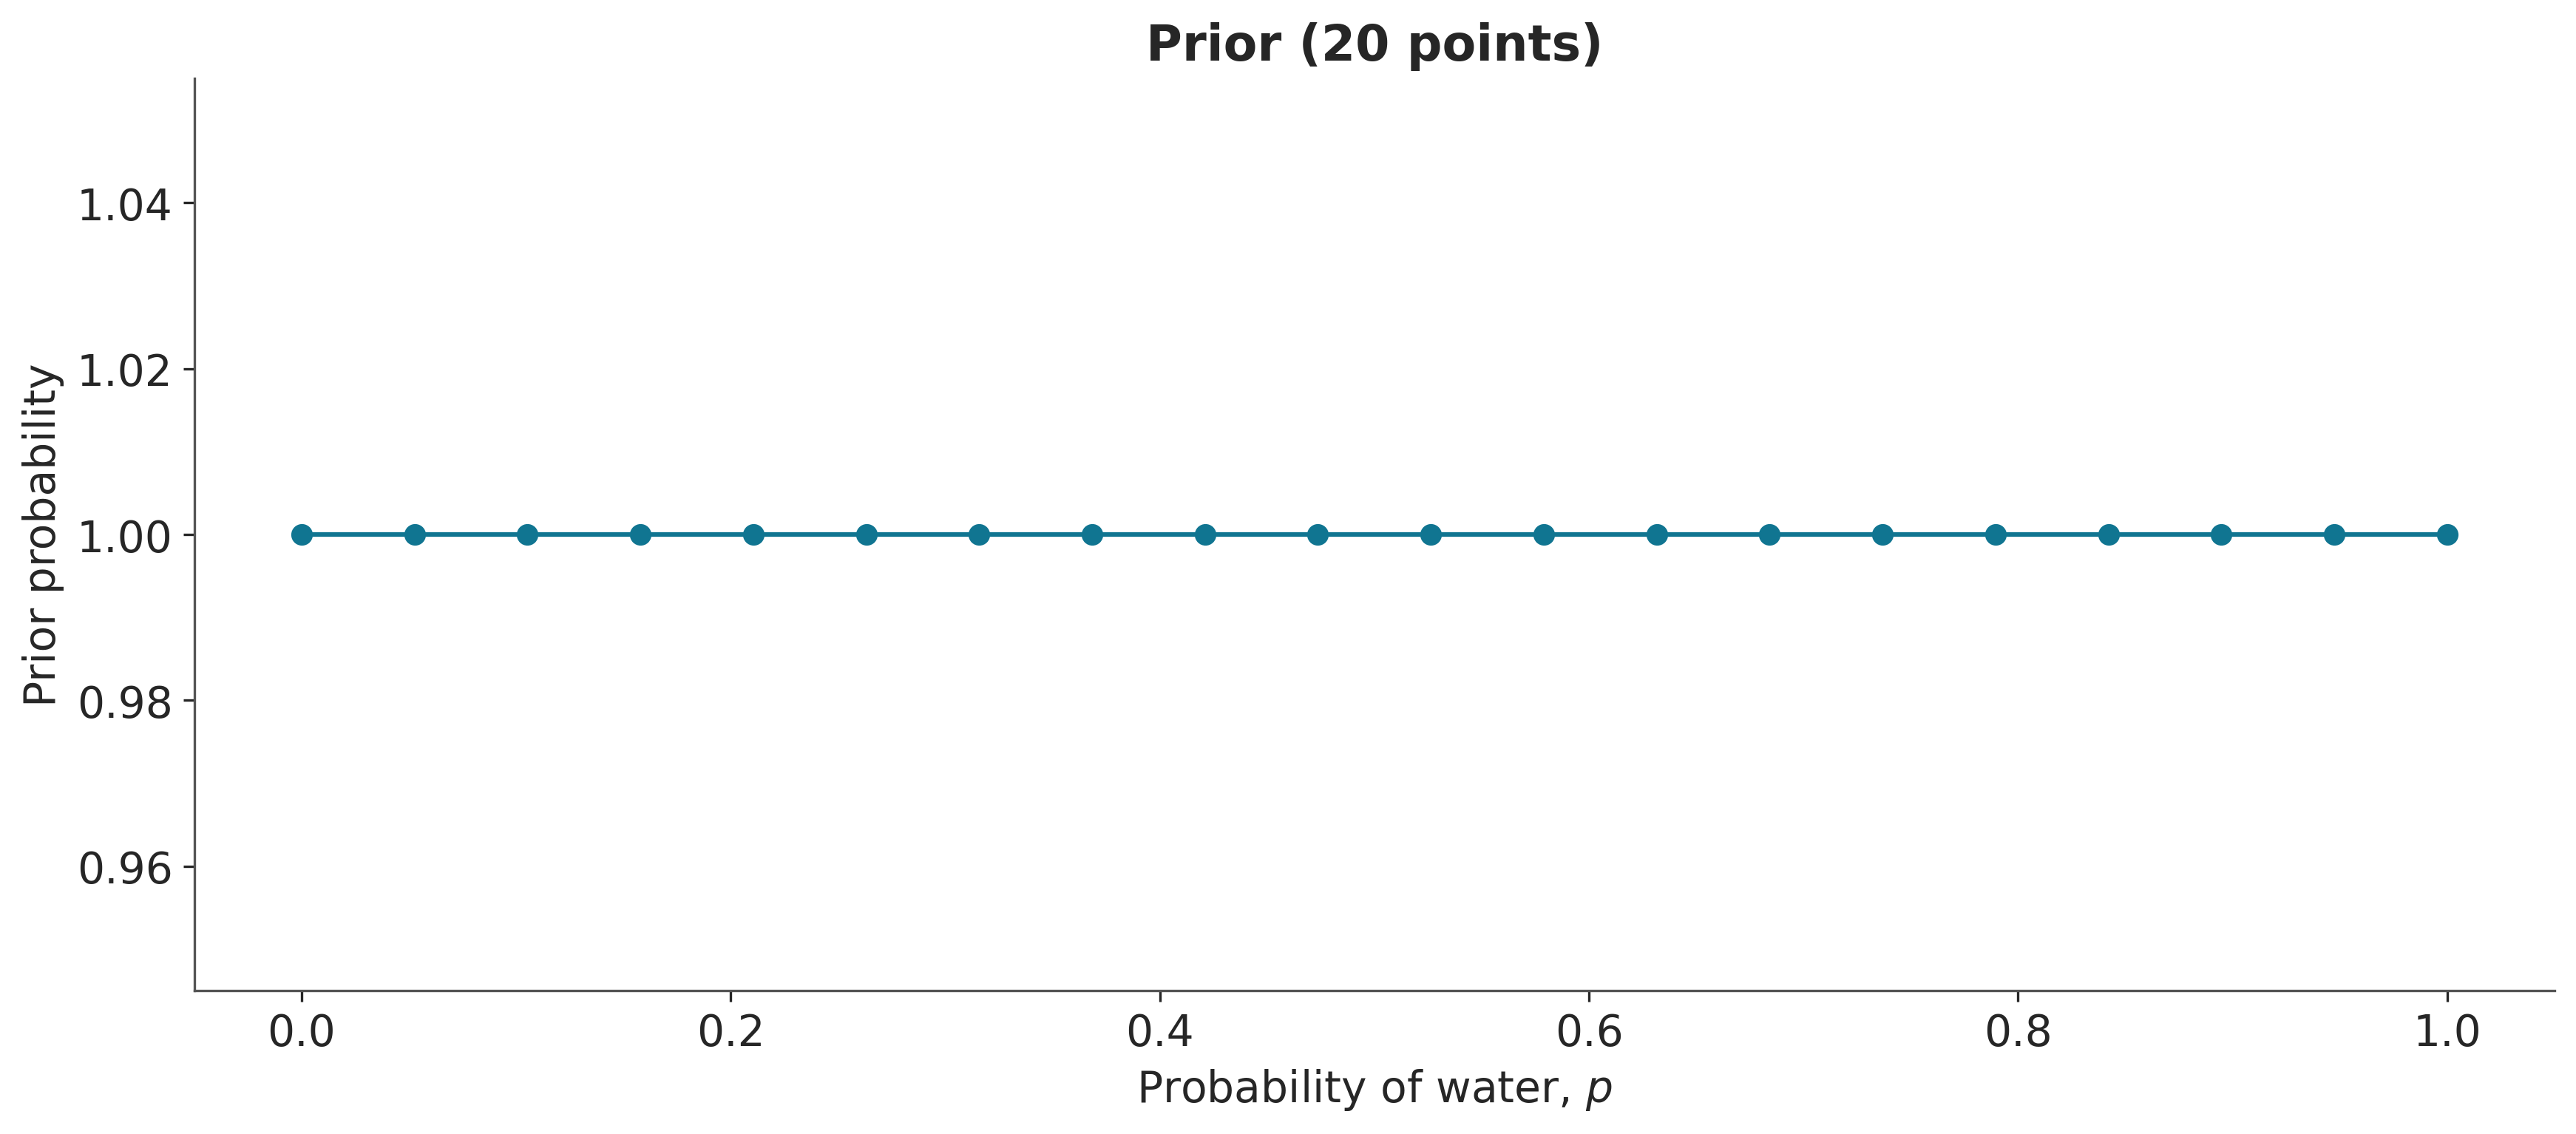

In [4]:
plt.plot(p_grid, prior, "-o")
plt.xlabel("Probability of water, $p$")
plt.ylabel("Prior probability")
plt.title("Prior (20 points)")
plt.show()

#### Likelihood, $Pr(N, W| p)$

>What is the probability of observing $W$ out of $N$ with a given $p$?

Likelihood is a distribution *function* assigned to an observed variable. It representes *how likely to get a specific observation.* 

In our example, every toss gives either land or water. Thus, we can assume that the number of water observations follow a binomial distribution, which requires **total number of observations** and **probability**.

$$W \sim \text{Binominal}(N, \, p)$$

Our observed data showed that we tossed 9 times ($N=9$) and got 6 water observations ($W=6$). For instance: $L, W, W, W, L, W, W, L, W$. 

With the binomial assumption, we now have a function of $N$ and $p$. If we assume that $p=0.5$ (equal coverage of water and land), what is the probability of getting this observation (6 waters out of 9 tosses)?

In [5]:
N = 9
W = 6
p = 0.5
jnp.exp(dist.Binomial(total_count=N, probs=p).log_prob(W))

Array(0.16406256, dtype=float32)

*Interpretation: if there's equal amount of water and land on the globe surface (p=0.5), there is 16% chance of observing 6 waters when tossing the globe 9 times.*

If we use different $p$, this value will change. For instance, if we think 90% is covered by water, the probability of observing 6 waters out of 9 tosses is:

In [6]:
jnp.exp(dist.Binomial(total_count=N, probs=0.9).log_prob(W))

Array(0.04464107, dtype=float32)

The distribution of $p$ comes from the prior we just defined (the uniform distribution). Thus, we can evaluate this probability for all possible points (20 points in our case) in this example.

In [7]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

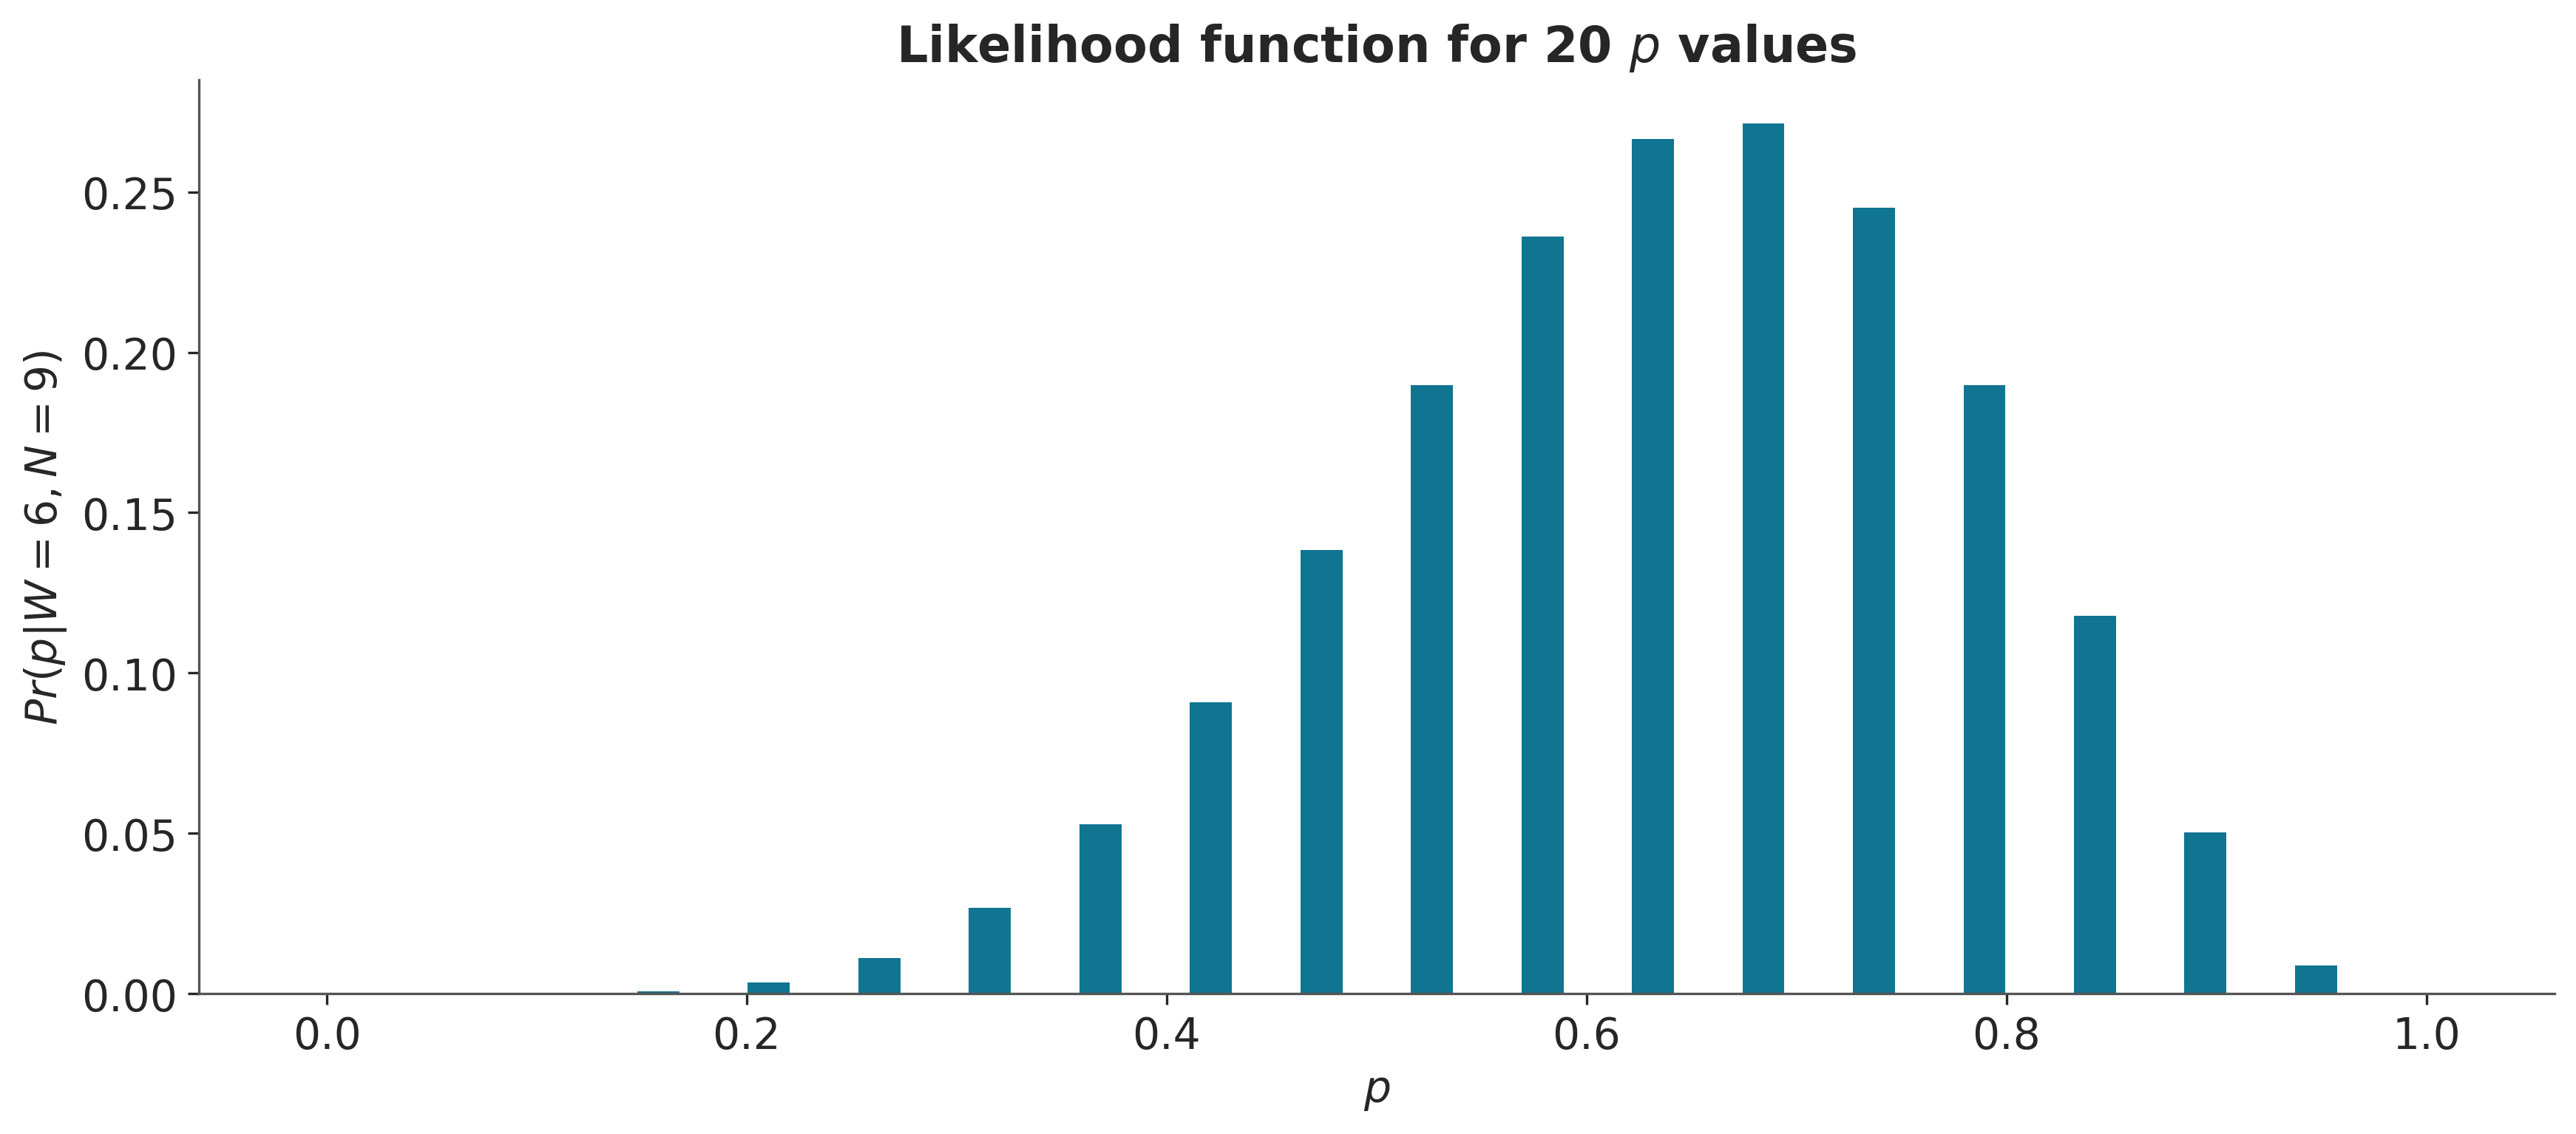

In [8]:
plt.bar(p_grid, likelihood, width=0.02)
plt.xlabel('$p$')
plt.ylabel('$Pr(p|W=6, N=9)$')
plt.title('Likelihood function for 20 $p$ values')
plt.show()

### Step 4. Compute the posterior

To compute the posterior, multiply prior and likelihood, and normalize (because it's a probability distribution).

In [9]:
unstd_posterior = prior * likelihood
posterior = unstd_posterior / jnp.sum(unstd_posterior)

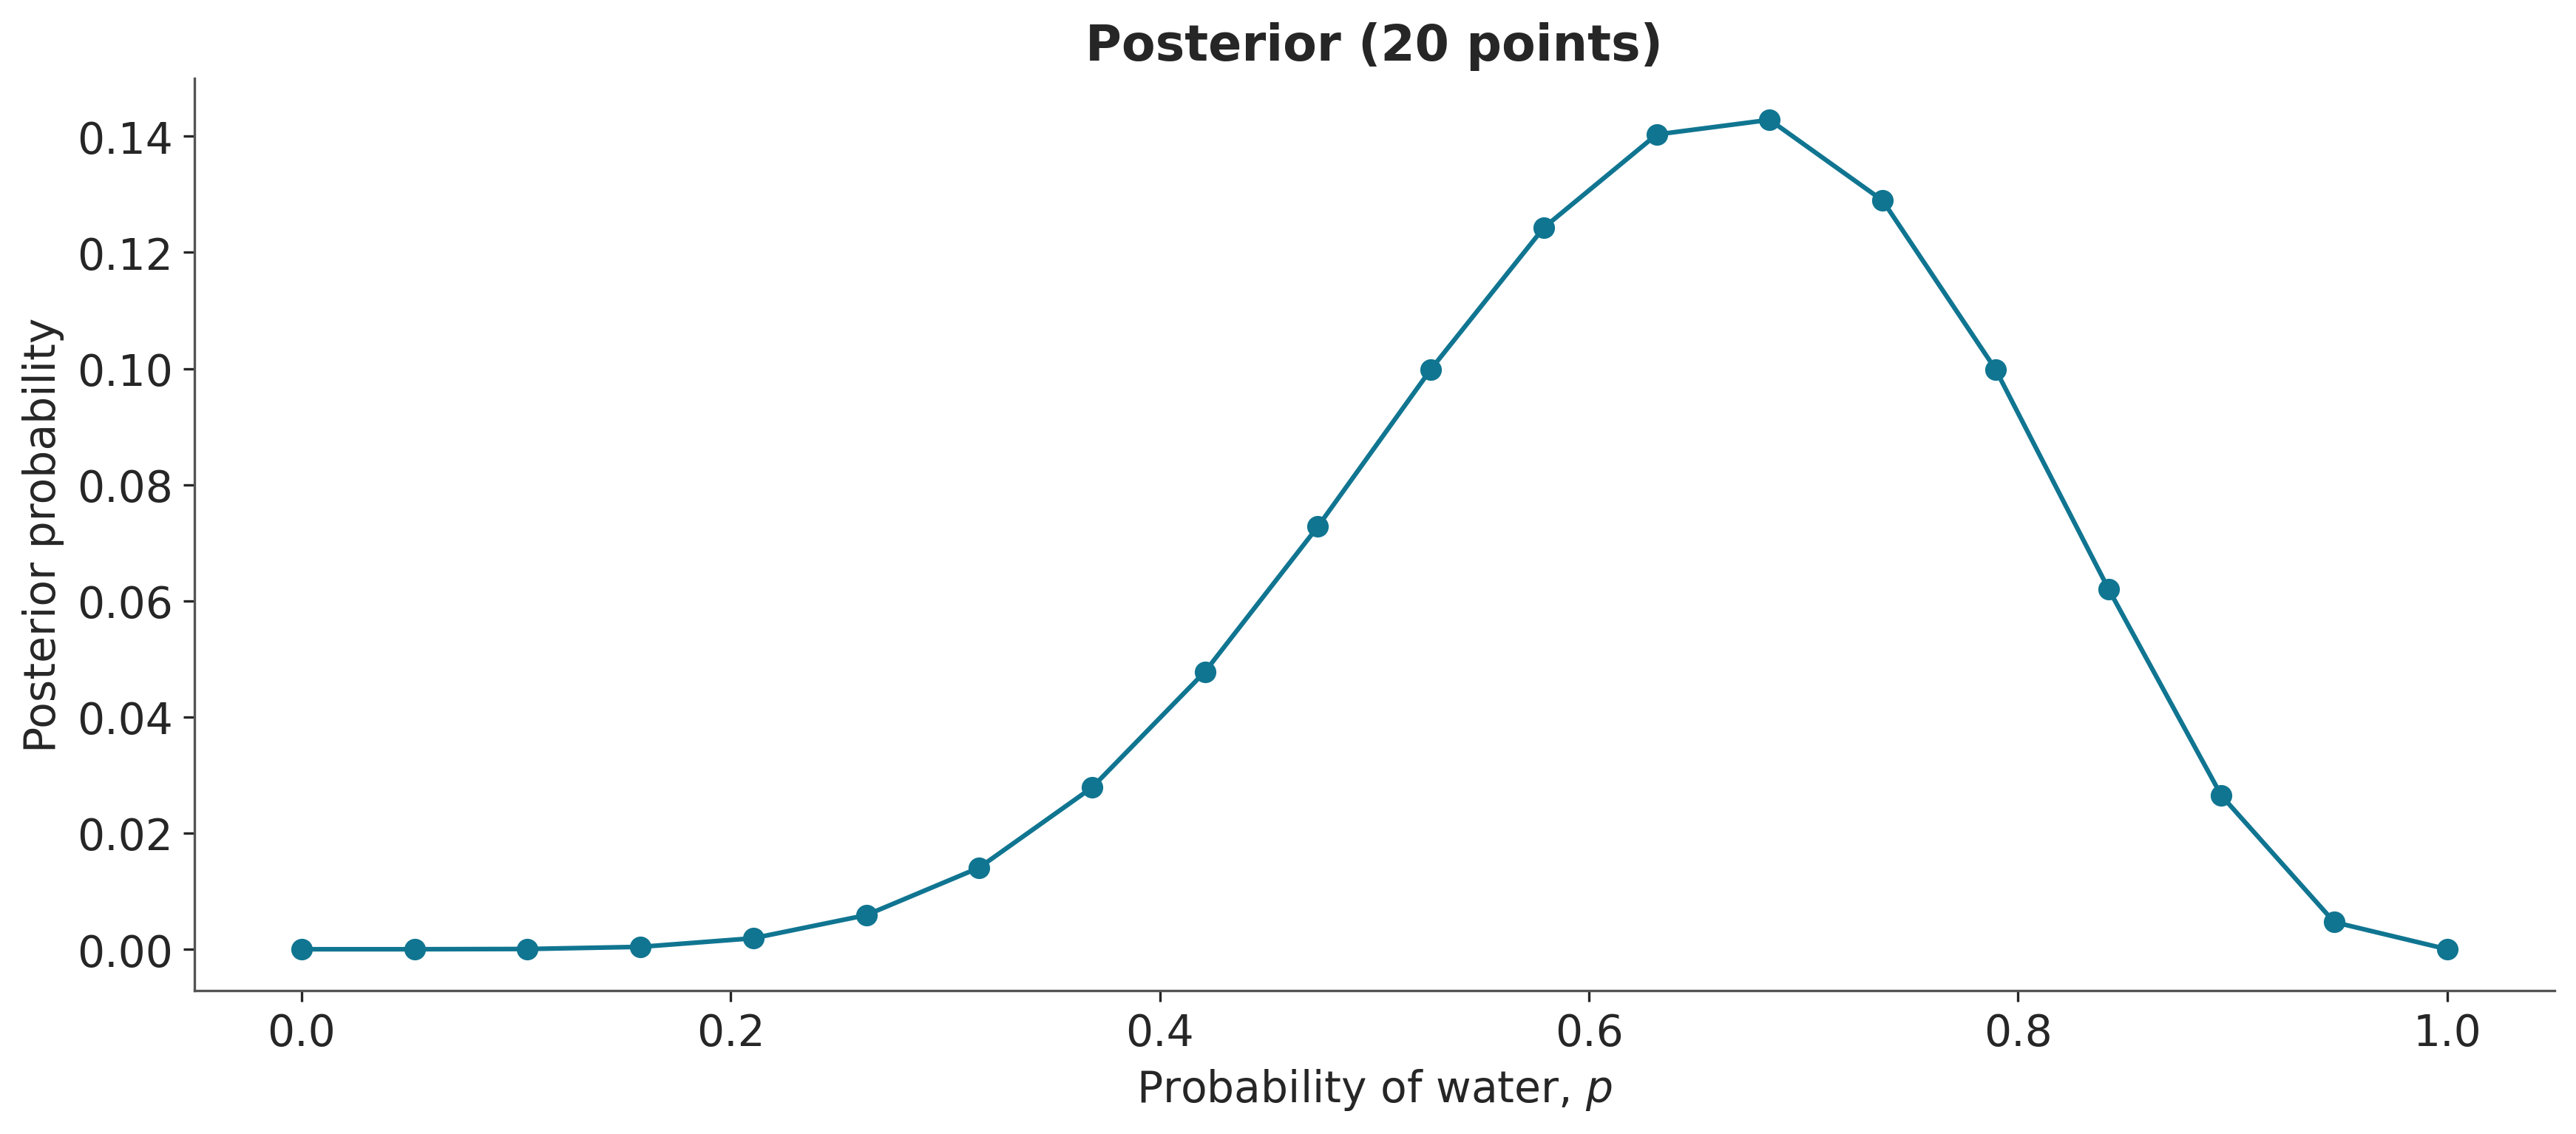

In [10]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("Probability of water, $p$")
plt.ylabel("Posterior probability")
plt.title("Posterior (20 points)")
plt.show()

### Posterior as Bayesian update
The posterior distributioin represents our **updated "belief" (prior) after we observe our data**. We can visualize how the posterior is updated for every observation (example observation: $L, W, W, W, L, W, W, L, W$)

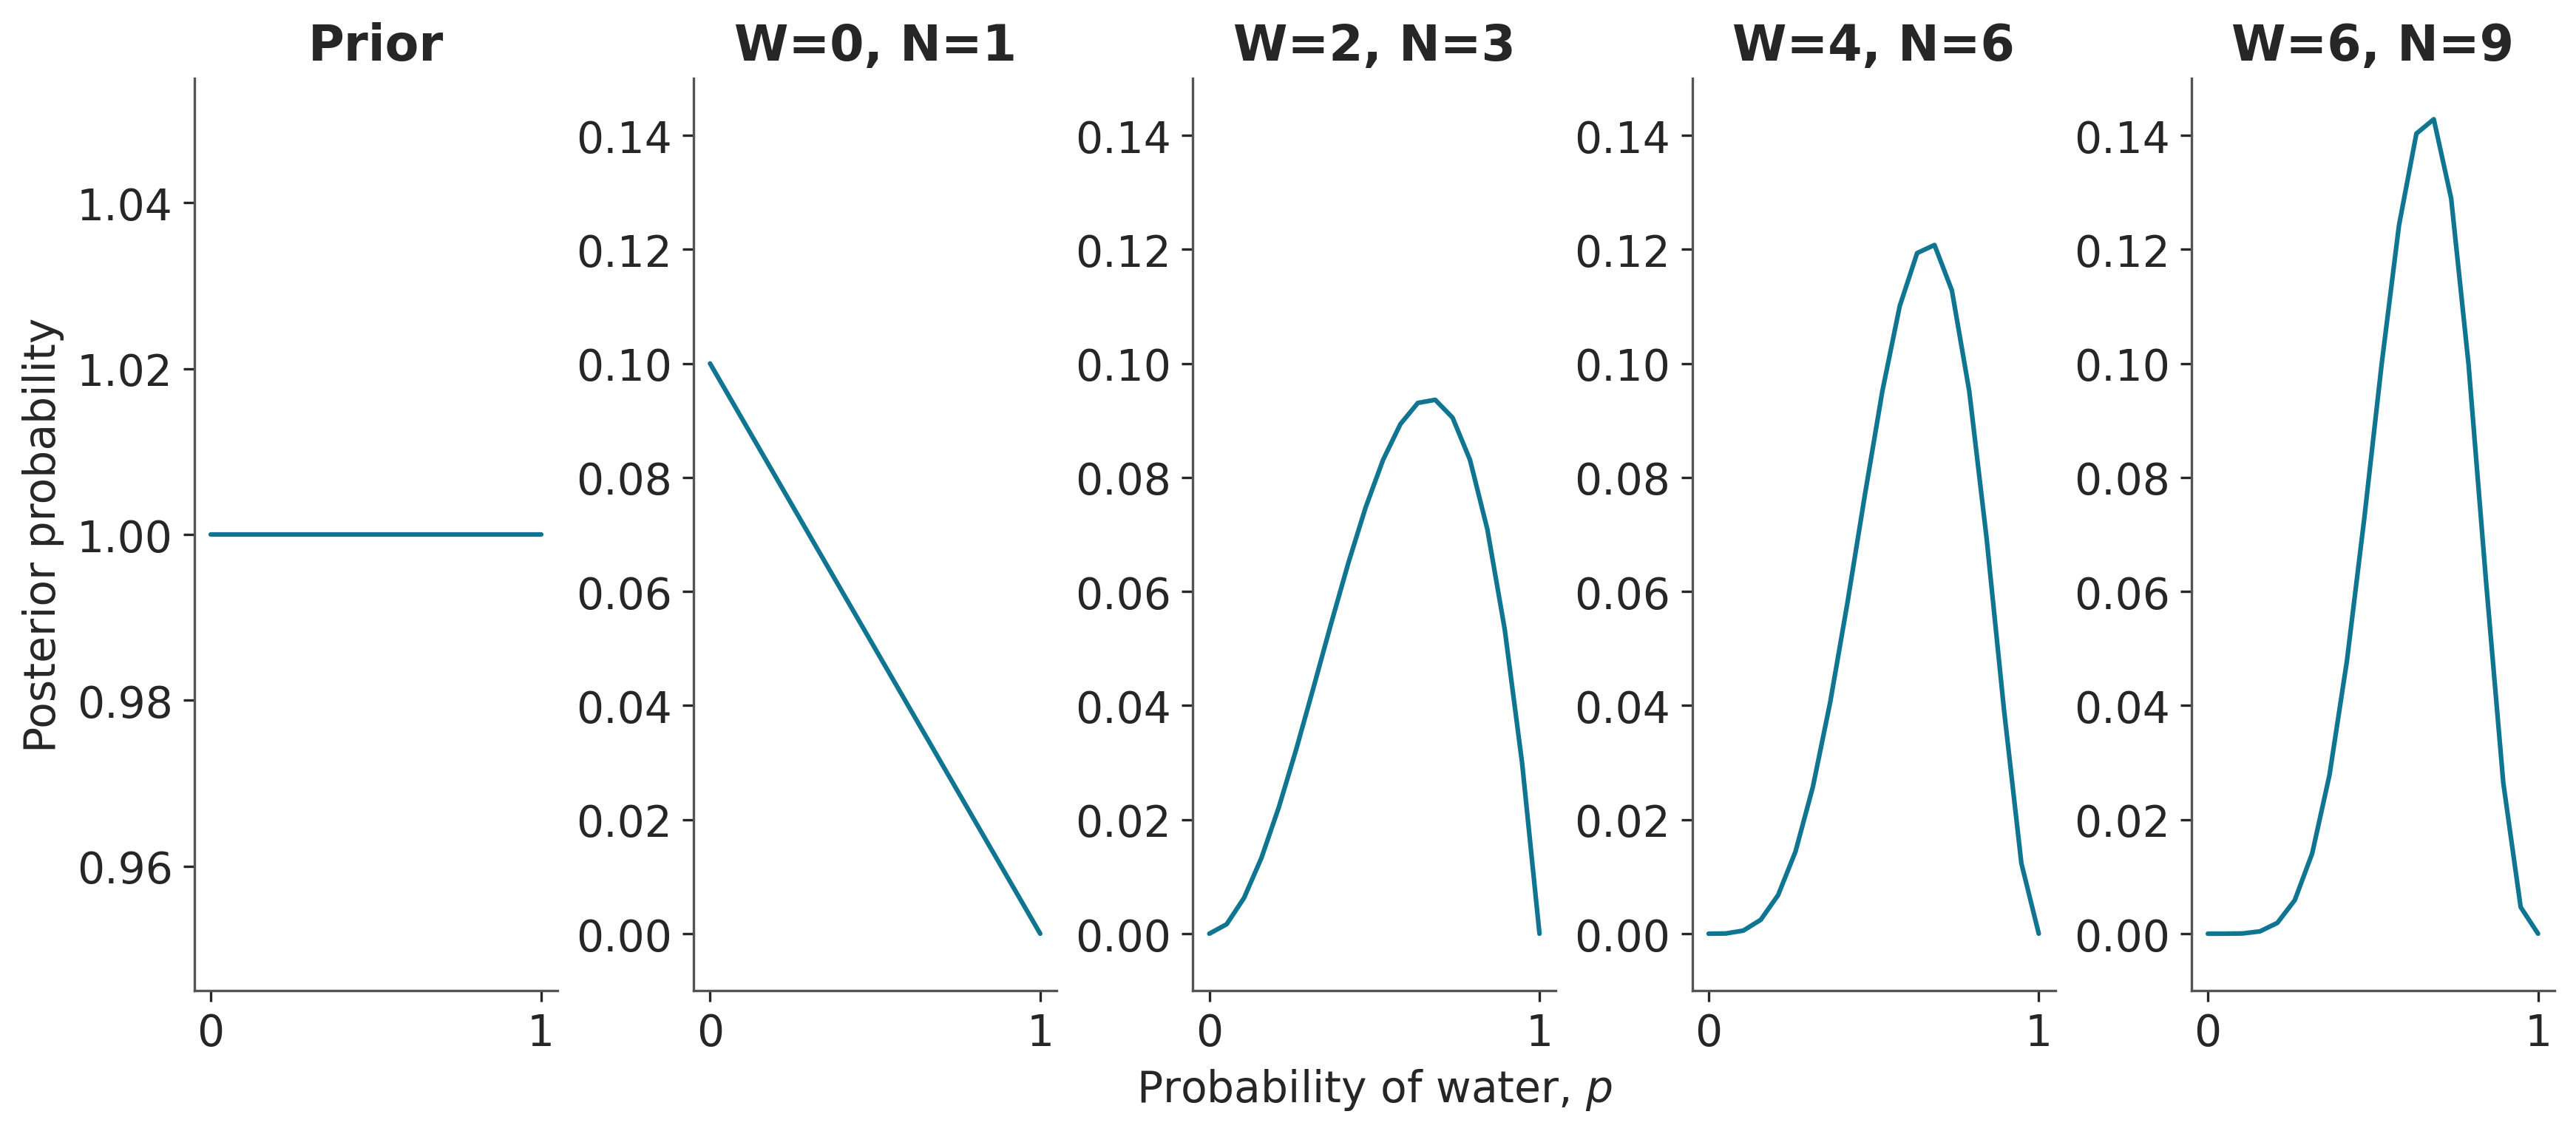

In [11]:
N_trials = [0, 1, 3, 6, 9]
N_waters = [0, 0, 2, 4, 6]

fig, axes = plt.subplots(1, len(N_trials), sharey=False, sharex=True)
for i, (N_water, N_trial, ax) in enumerate(zip(N_waters, N_trials, axes)):
    if i == 0:
        ax.plot(p_grid, prior, '-')
        ax.set(ylabel='Posterior probability', title='Prior')
    else:
        likelihood = jnp.exp(dist.Binomial(total_count=N_trial, probs=p_grid).log_prob(N_water))
        unstd_posterior = prior * likelihood
        posterior = unstd_posterior / jnp.sum(unstd_posterior)
        ax.plot(p_grid, posterior, "-")
        ax.set_title("W={}, N={}".format(N_water, N_trial))
        ax.set_ylim(-0.01, 0.15)
    if i == 2:
        ax.set_xlabel("Probability of water, $p$")
plt.show()

We just computed the posterior for every point in a grid. This method is called **grid approdximation**. You can apply this method to any models but it's compute-intensive. A commonly used alternative is **MCMC**.

### Impact of prior

Let's use a different prior (*non-uniform*) and see how the posterior distribution changes. Below, we have a sharp prior centered around 0.5 (=we have a strong belief that $p$ is centered around 0.5).

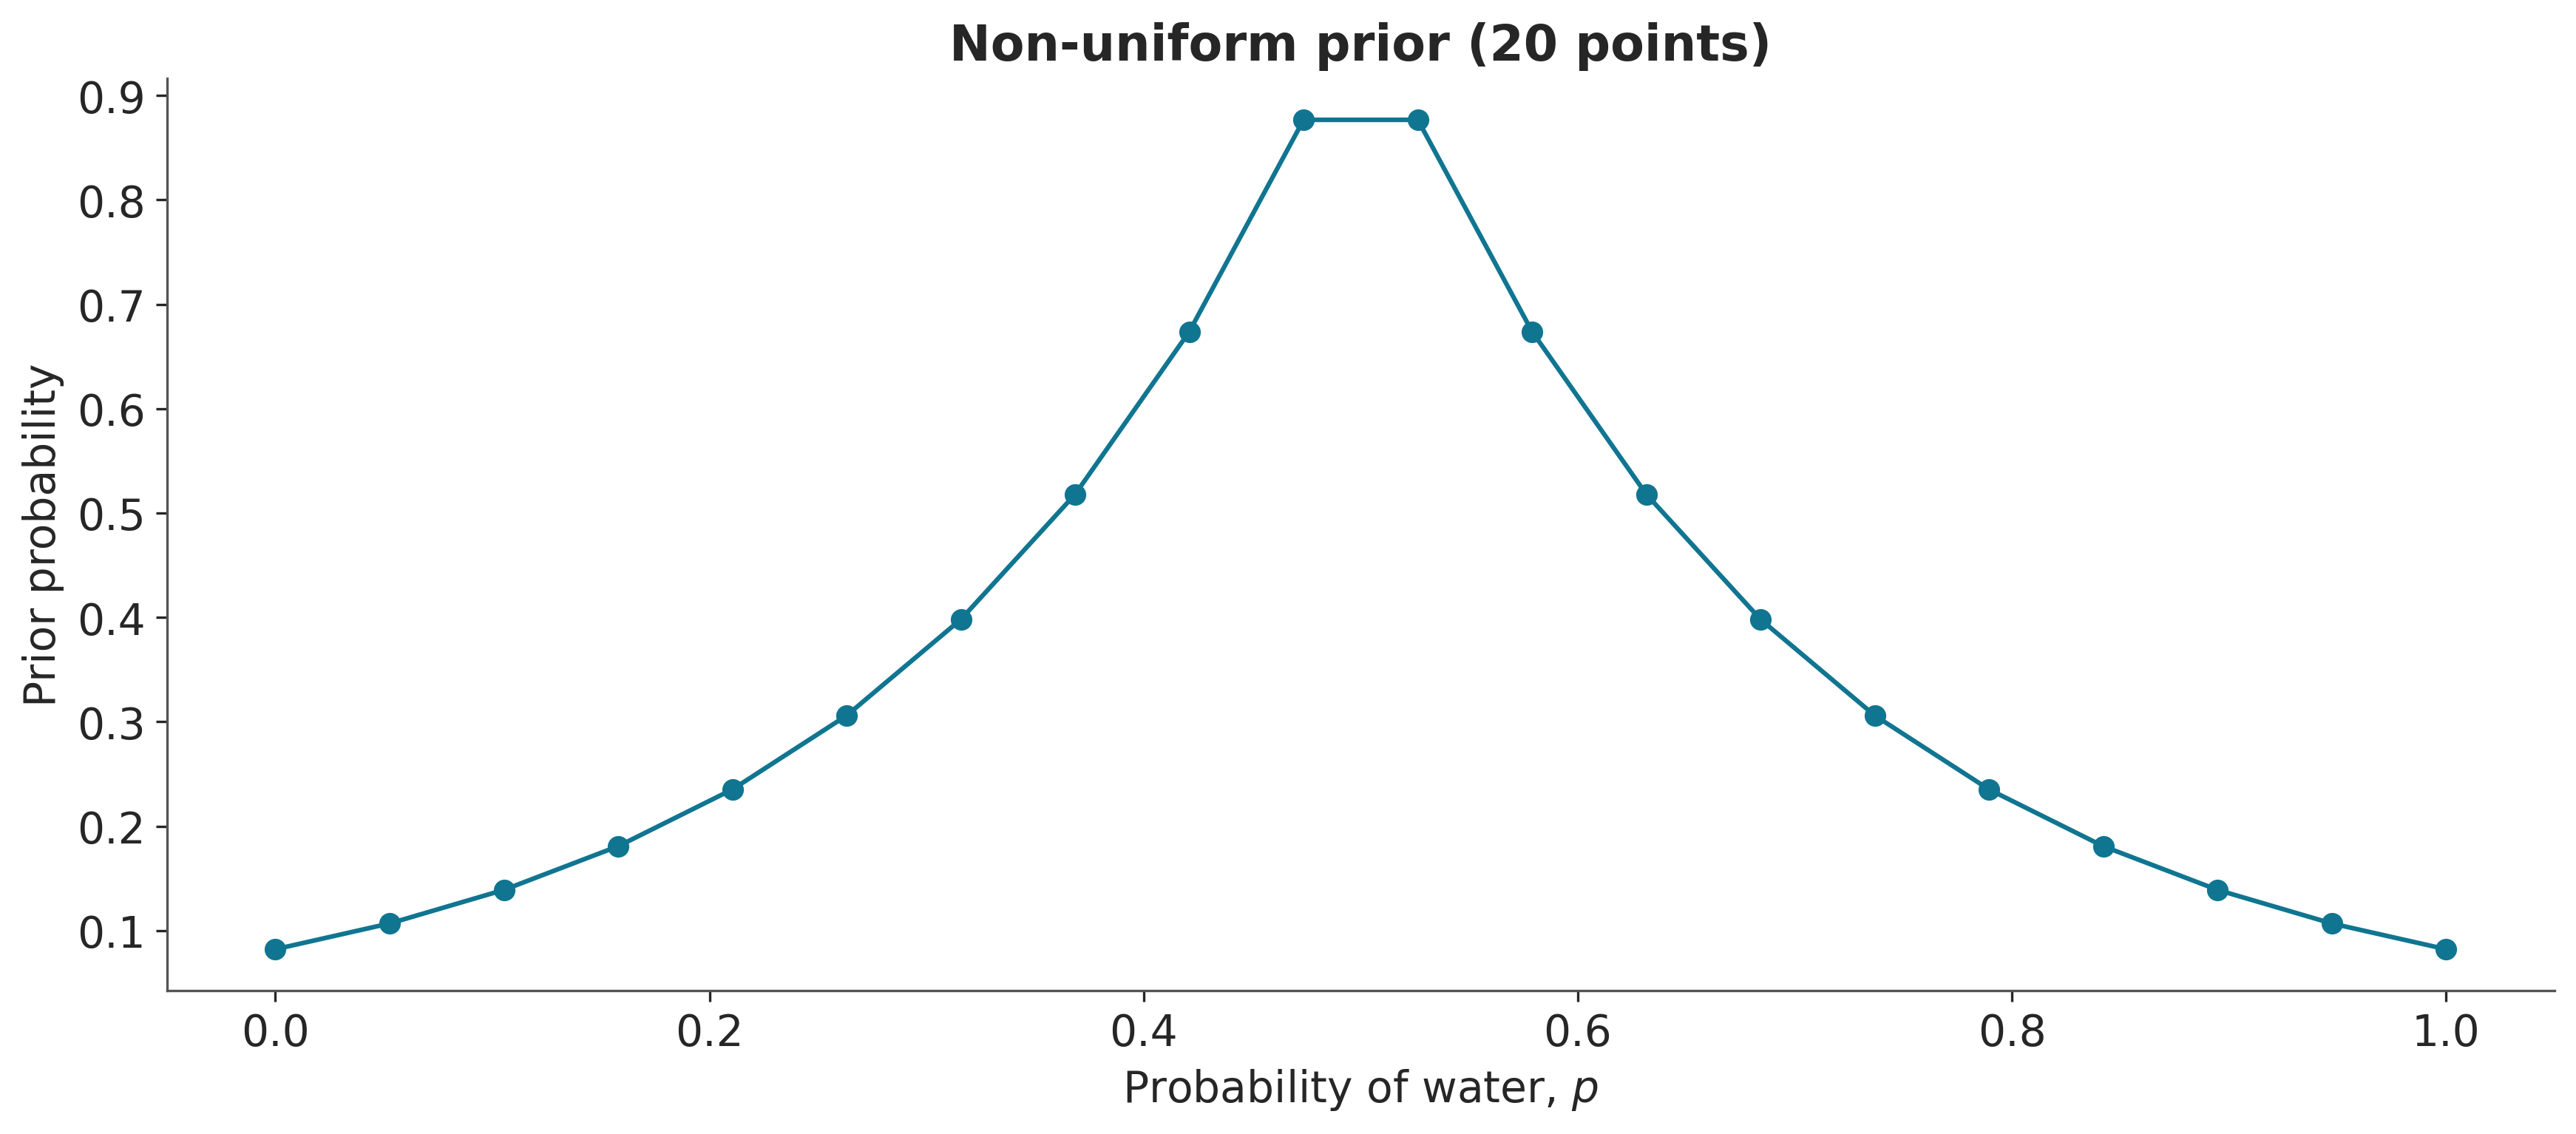

In [12]:
prior_sharp = jnp.where(p_grid < 0.5, 0, 1)
prior_sharp = jnp.exp(-5 * abs(p_grid - 0.5))

plt.plot(p_grid, prior_sharp, "-o")
plt.xlabel("Probability of water, $p$")
plt.ylabel("Prior probability")
plt.title("Non-uniform prior (20 points)")
plt.show()

Let's calculate posterior based on this prior and compare this with the previous result (from the uniform prior).

In [13]:
unstd_posterior_sharp = likelihood * prior_sharp
posterior_sharp = unstd_posterior_sharp / jnp.sum(unstd_posterior_sharp)

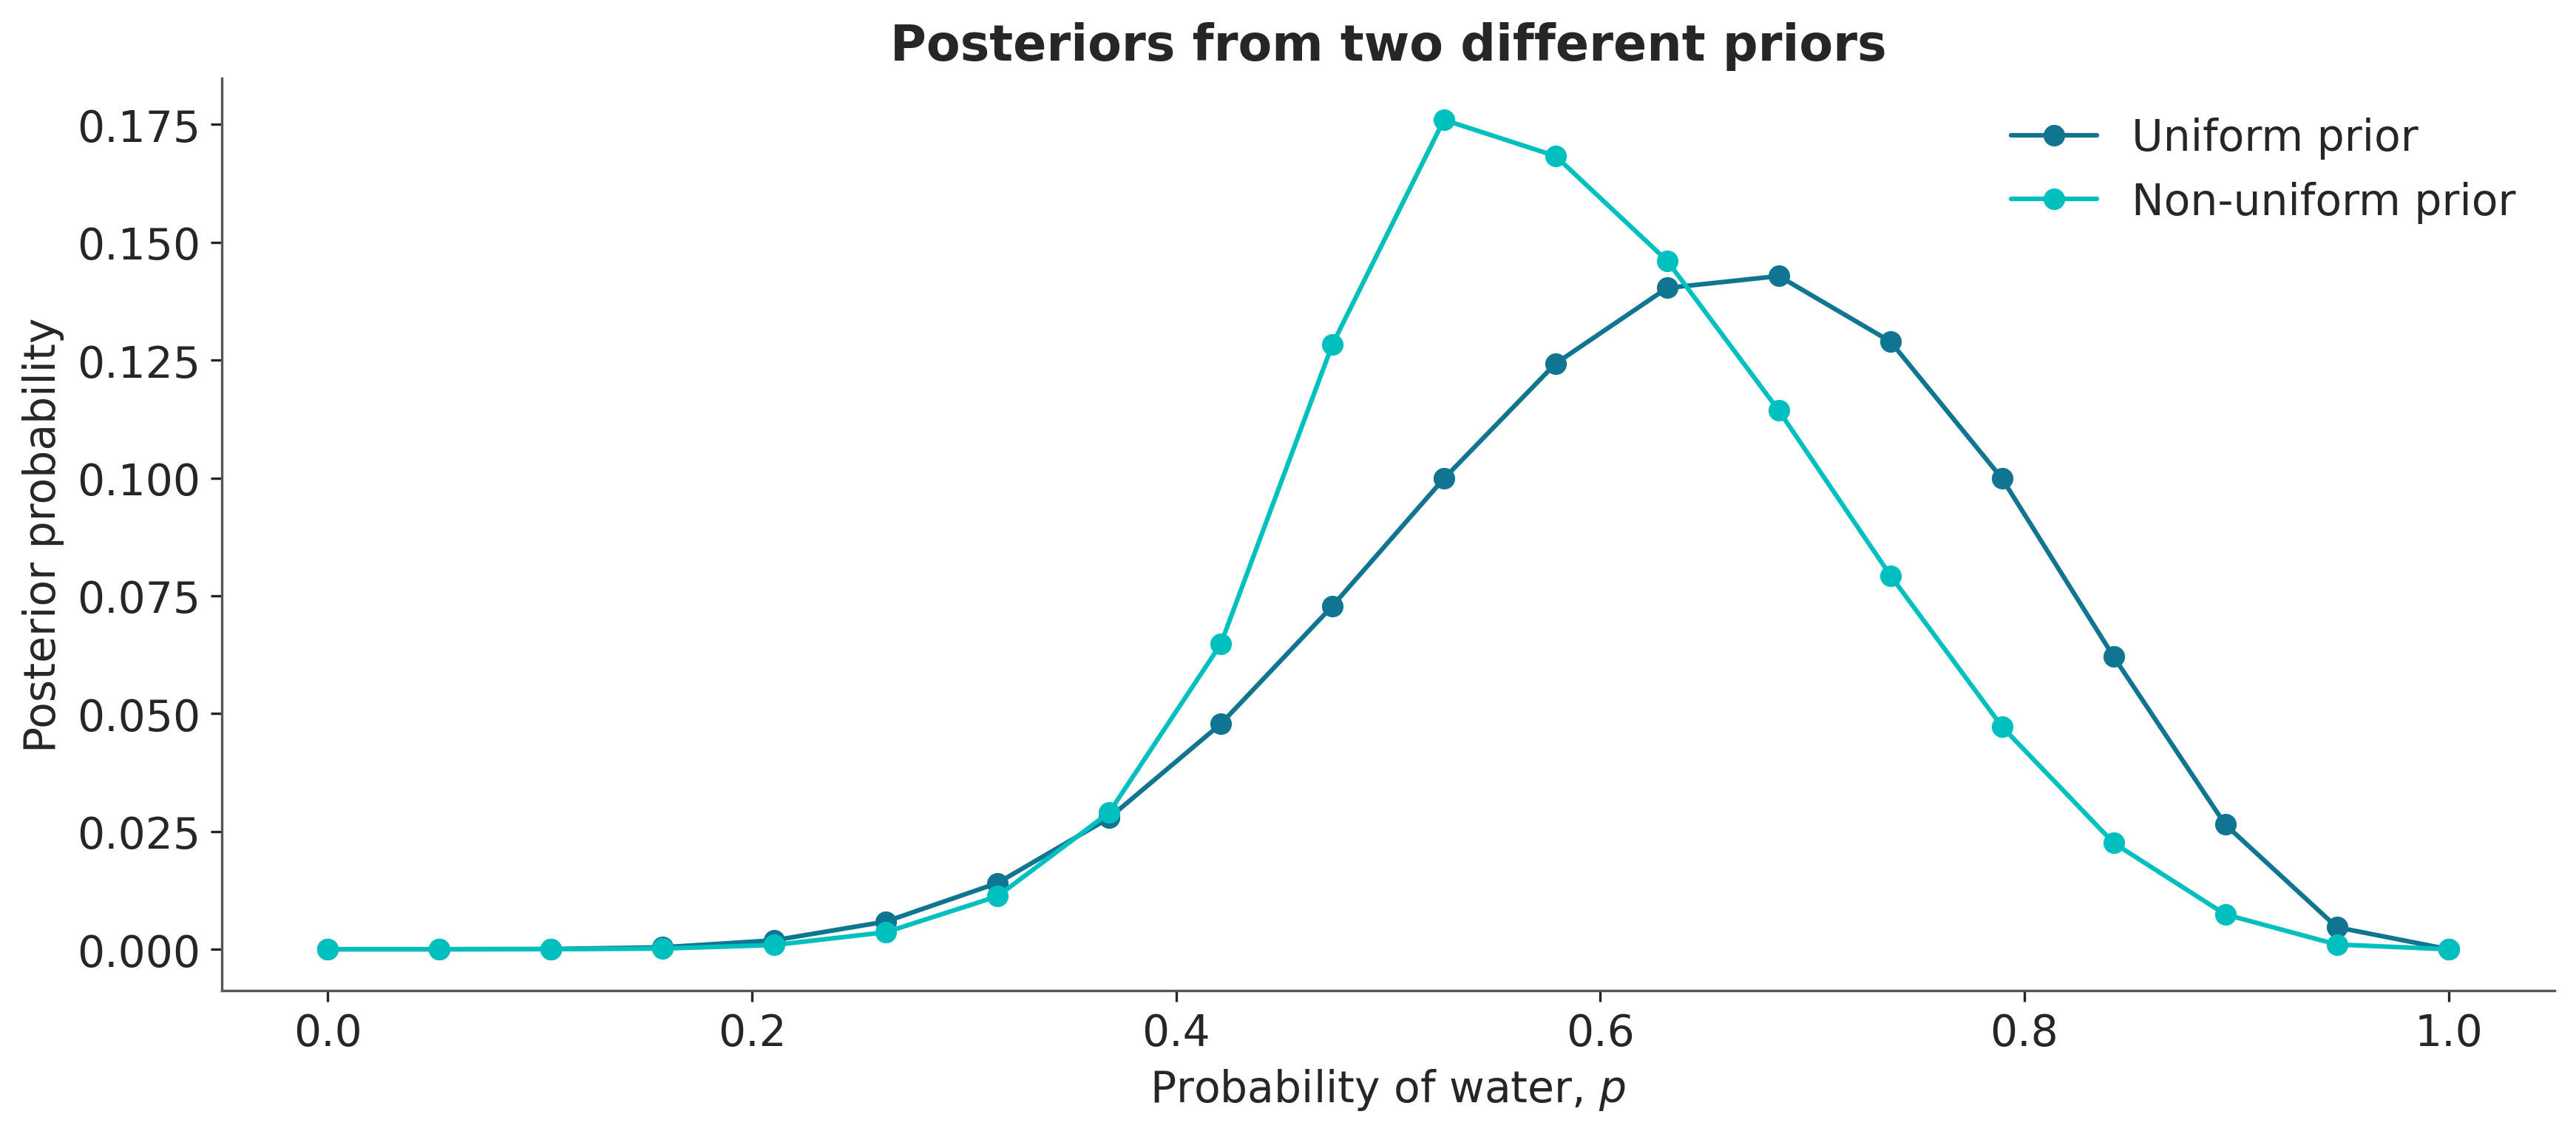

In [14]:
plt.plot(p_grid, posterior, "-o", label='Uniform prior')
plt.plot(p_grid, posterior_sharp, "-o", label='Non-uniform prior')
plt.xlabel("Probability of water, $p$")
plt.ylabel("Posterior probability")
plt.title("Posteriors from two different priors")
plt.legend()
plt.show()

The peak of the posterior is shifted towards 0.5 when we use the non-uniform prior, which shows that the sharp peak around 0.5 affected the shape of posterior distribution.

A **tighter prior (skeptical prior)** is less likely swayed by observations than the flat prior. But, if the prior is too tight, then it just ignores observations too often (very strong belief).

## Toy example 2: Bayesian linear regression

This example shows how we can use Bayesian data analysis for predictive modeling.

### Setup
- Question: estimate (predict) height of an adult given their weight
- Observations
    - Height (cm)
    - Weight (kg)
    - N = 352

### Data

In [15]:
df = pd.read_csv("../Data/Howell1.csv", sep=';')
df = df[df.age >= 18] # using adult data only
df.describe()

height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

### Simple exploratory data analysis

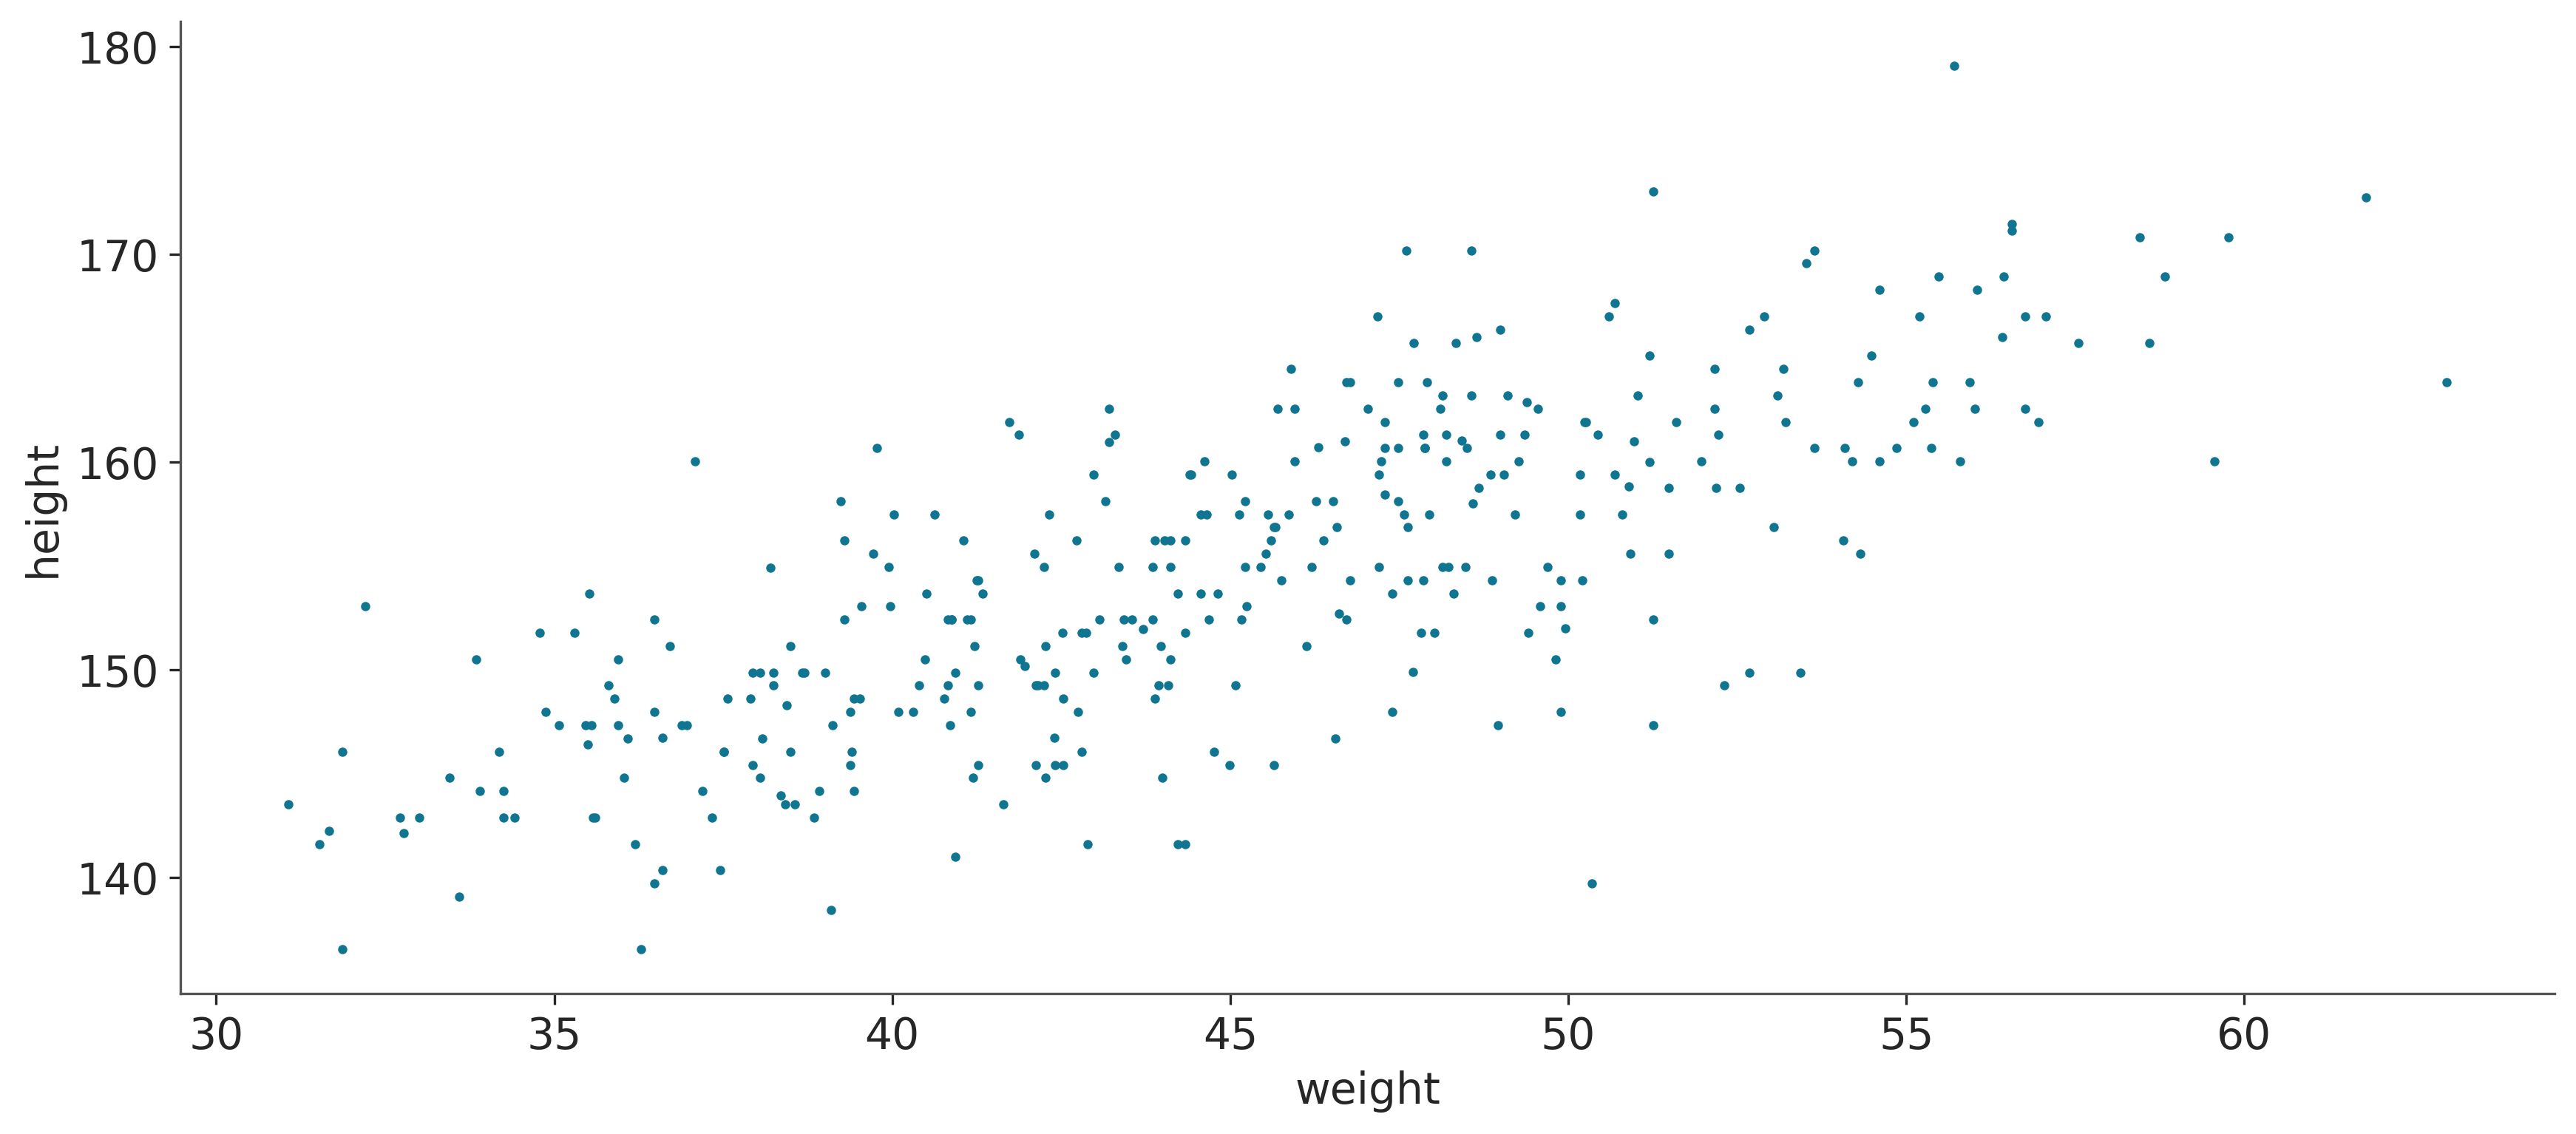

In [16]:
az.plot_pair(df[["weight", "height"]].to_dict(orient="list"))
plt.show()

There's a linear relationship between the two variables.

### Step 1. Draw a DAG
We want to predict height $H$ from weight $W$.

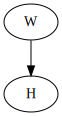

In [17]:
globe_toss = CausalGraphicalModel(
    nodes = ["W", "H"],
    edges = [
        ("W", "H"),
    ]
)

globe_toss.draw()

We can assume observation that there are some unknown errors such as measurement errors in height measurements. In this case, we can say the **height data comes from a normal distribution defined by $\mu$ and $\sigma$**:
$$H \sim \text{Normal}(\mu, \, \sigma)$$

Here, we assume that there is a **linear** relationship between height and weight. Then, we can say the **$\mu$ is a linear function of $W$**:
$$\mu = \alpha + \beta (W - \bar{W})$$

($\bar{W}$: mean of $W$)

Then the DAG looks like this:

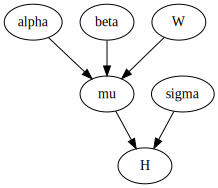

In [18]:
height_weight = CausalGraphicalModel(
    nodes = ["mu", "sigma", "alpha", "beta", "W", "H"],
    edges = [
        ("mu", "H"),
        ("sigma", "H"),
        ("alpha", "mu"),
        ("beta", "mu"),
        ("W", "mu"),
    ]
)

height_weight.draw()

Then our model parameters are
- $\alpha$: intercept
- $\beta$: slope
- $\sigma$: standard deviation

and the observation is $W$.

(Note: $\mu$ is not a parameter because it is deterministically defined by $\alpha$ and $\beta$.

### Step 2. Define the posterior

We want to predict $H$ given model parameters and observation. Thus, the posterior is:

$$Pr(H | \alpha, \beta, \sigma, W)$$

### Step 3. Define the priors

Let's define the following arbitrary distributions.

$$
\begin{align}
\alpha \sim \text{Normal}(178,\,20) \\
\beta \sim \text{Normal}(0,\,10) \\
\sigma \sim \text{Uniform}(0,\,50) 
\end{align}
$$

#### Prior predictive distribution check
We can use our data to check whether our prior choice makes sense. Let's focus on $\beta$ (slope of the linear function) here:
$$\beta \sim \text{Normal}(0,\,10)$$

First, check the scatter plot above again. At a glance, we see that the slope should positive and close to 1. Considering this, the above prior has the following issues:
- It is too flat (the standard deviation is 10).
- It can have negative values (it's a normal distribution with mean of 0).

We can consider a different prior:
$$\beta \sim \text{LogNormal}(0,\,1)$$

Let's visualize the distribution of $\beta$ for the two priors:

In [19]:
with numpyro.handlers.seed(rng_seed=0):
    N = 100  # 100 samples
    alpha = numpyro.sample("alpha", dist.Normal(178, 28).expand([N]))
    beta_vague = numpyro.sample("beta", dist.Normal(0, 10).expand([N]))
    beta_tighter = numpyro.sample("beta", dist.LogNormal(0, 1).expand([N]))

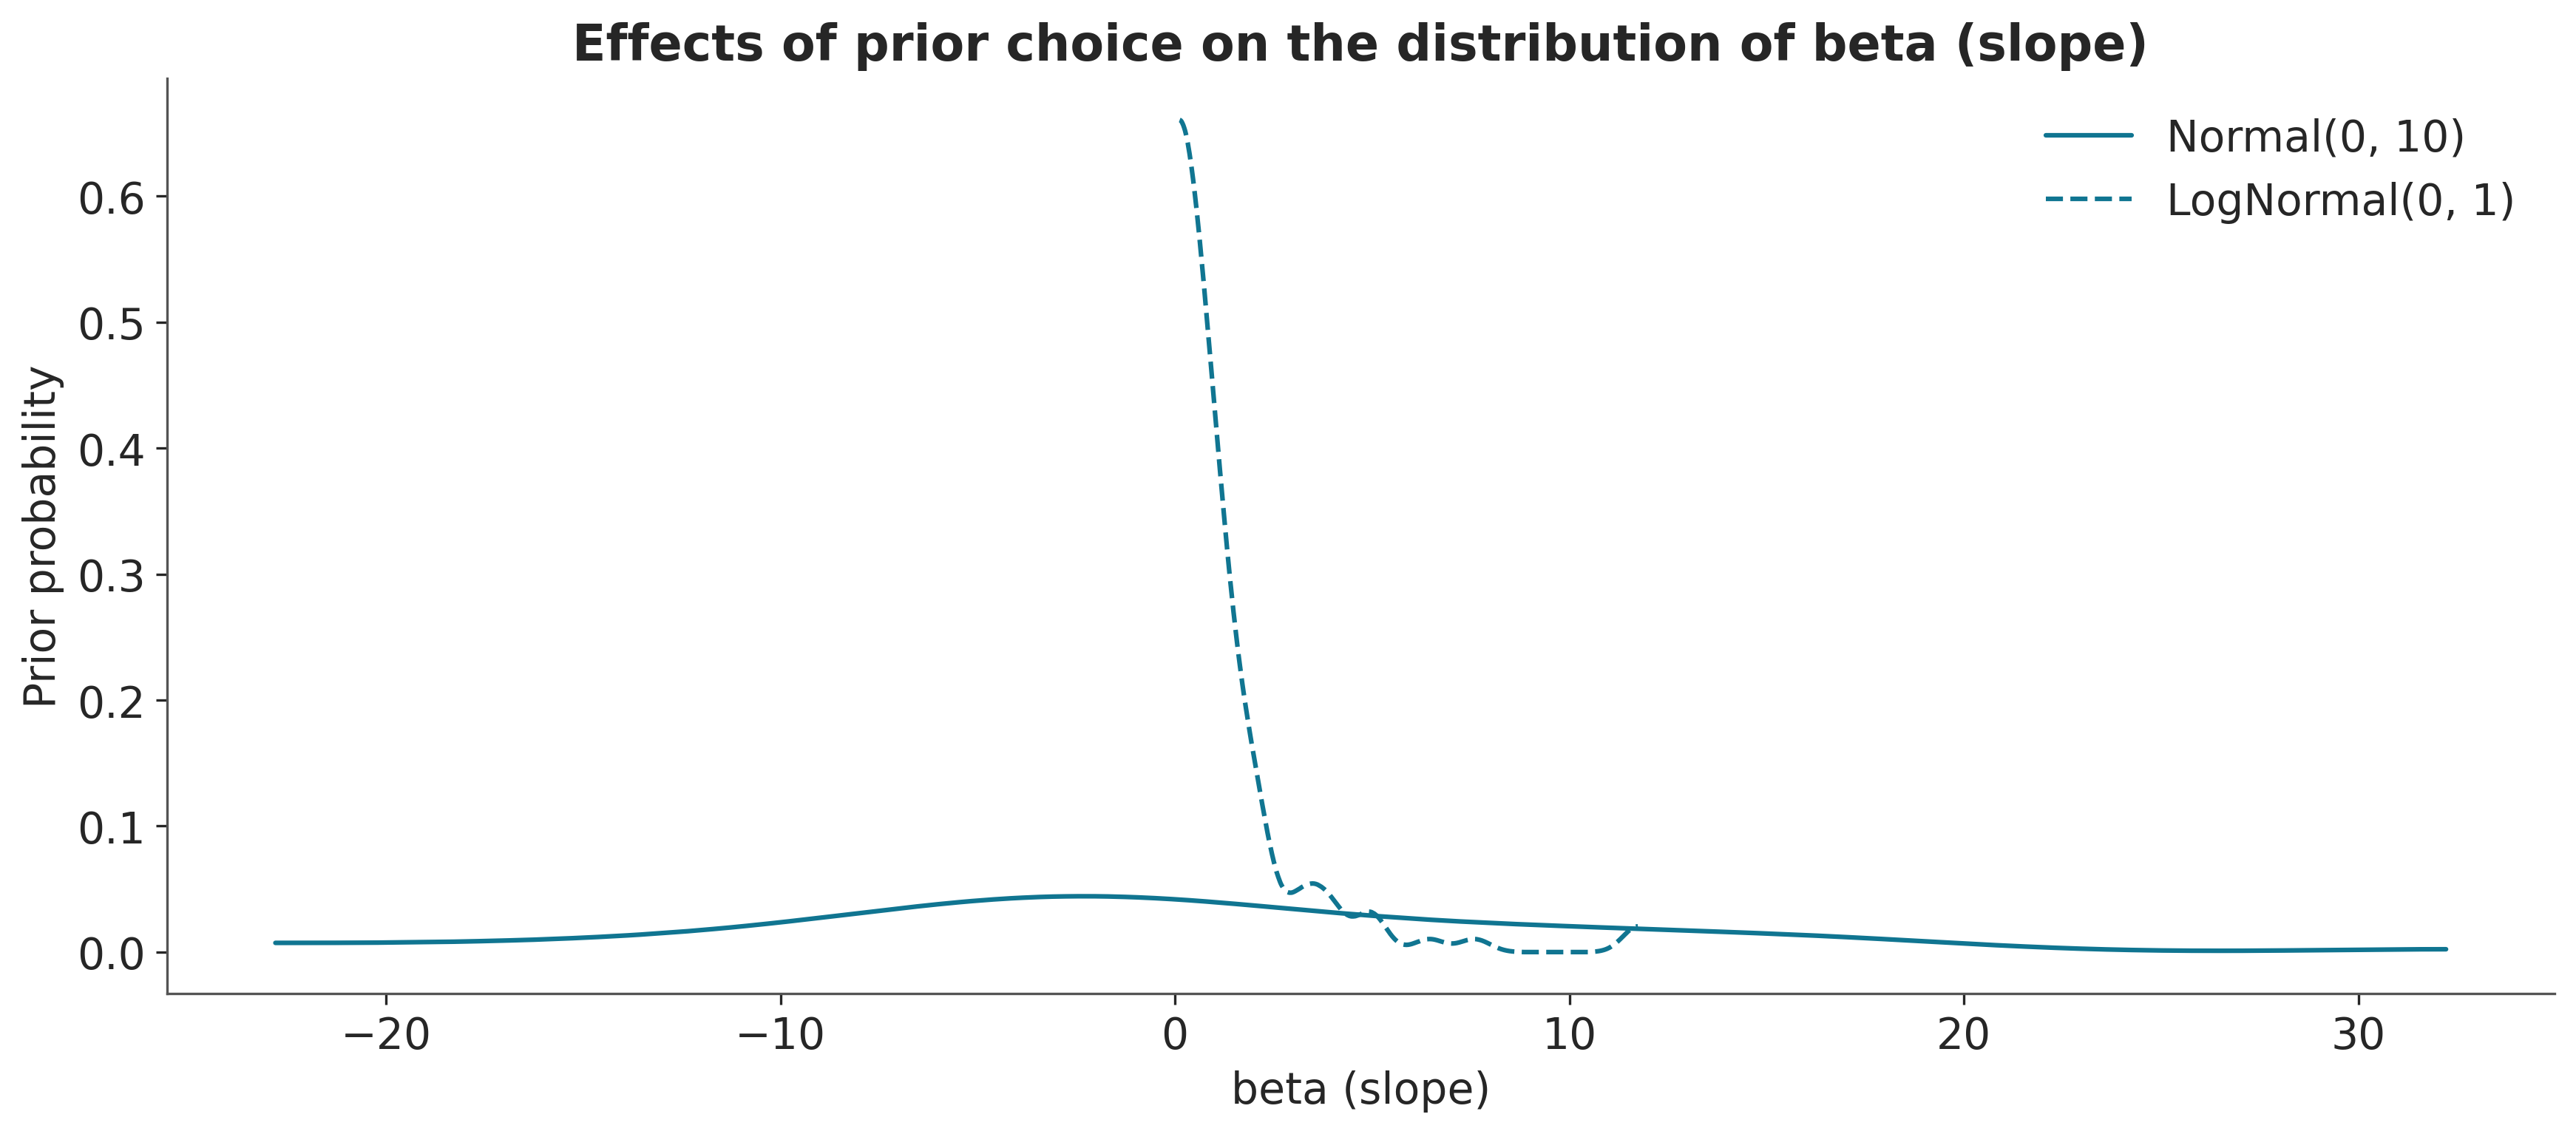

In [20]:
fig, ax = plt.subplots()
az.plot_kde(beta_vague, label='Normal(0, 10)', ax=ax)
az.plot_kde(beta_tighter, label='LogNormal(0, 1)', plot_kwargs={"linestyle":"--"}, ax=ax)
ax.set_title('Effects of prior choice on the distribution of beta (slope)')
ax.set(ylabel='Prior probability', xlabel='beta (slope)')
ax.legend()
plt.show()

As we expected the normal prior is almost flat and there are some probabilities assigned to negative values. Most of the probability mass of the log normal prior is centered around 0 and it only considers positive values.

Since $\beta$ is the slope of the linear function, we can visualize the relationship between $W$ and $H$.

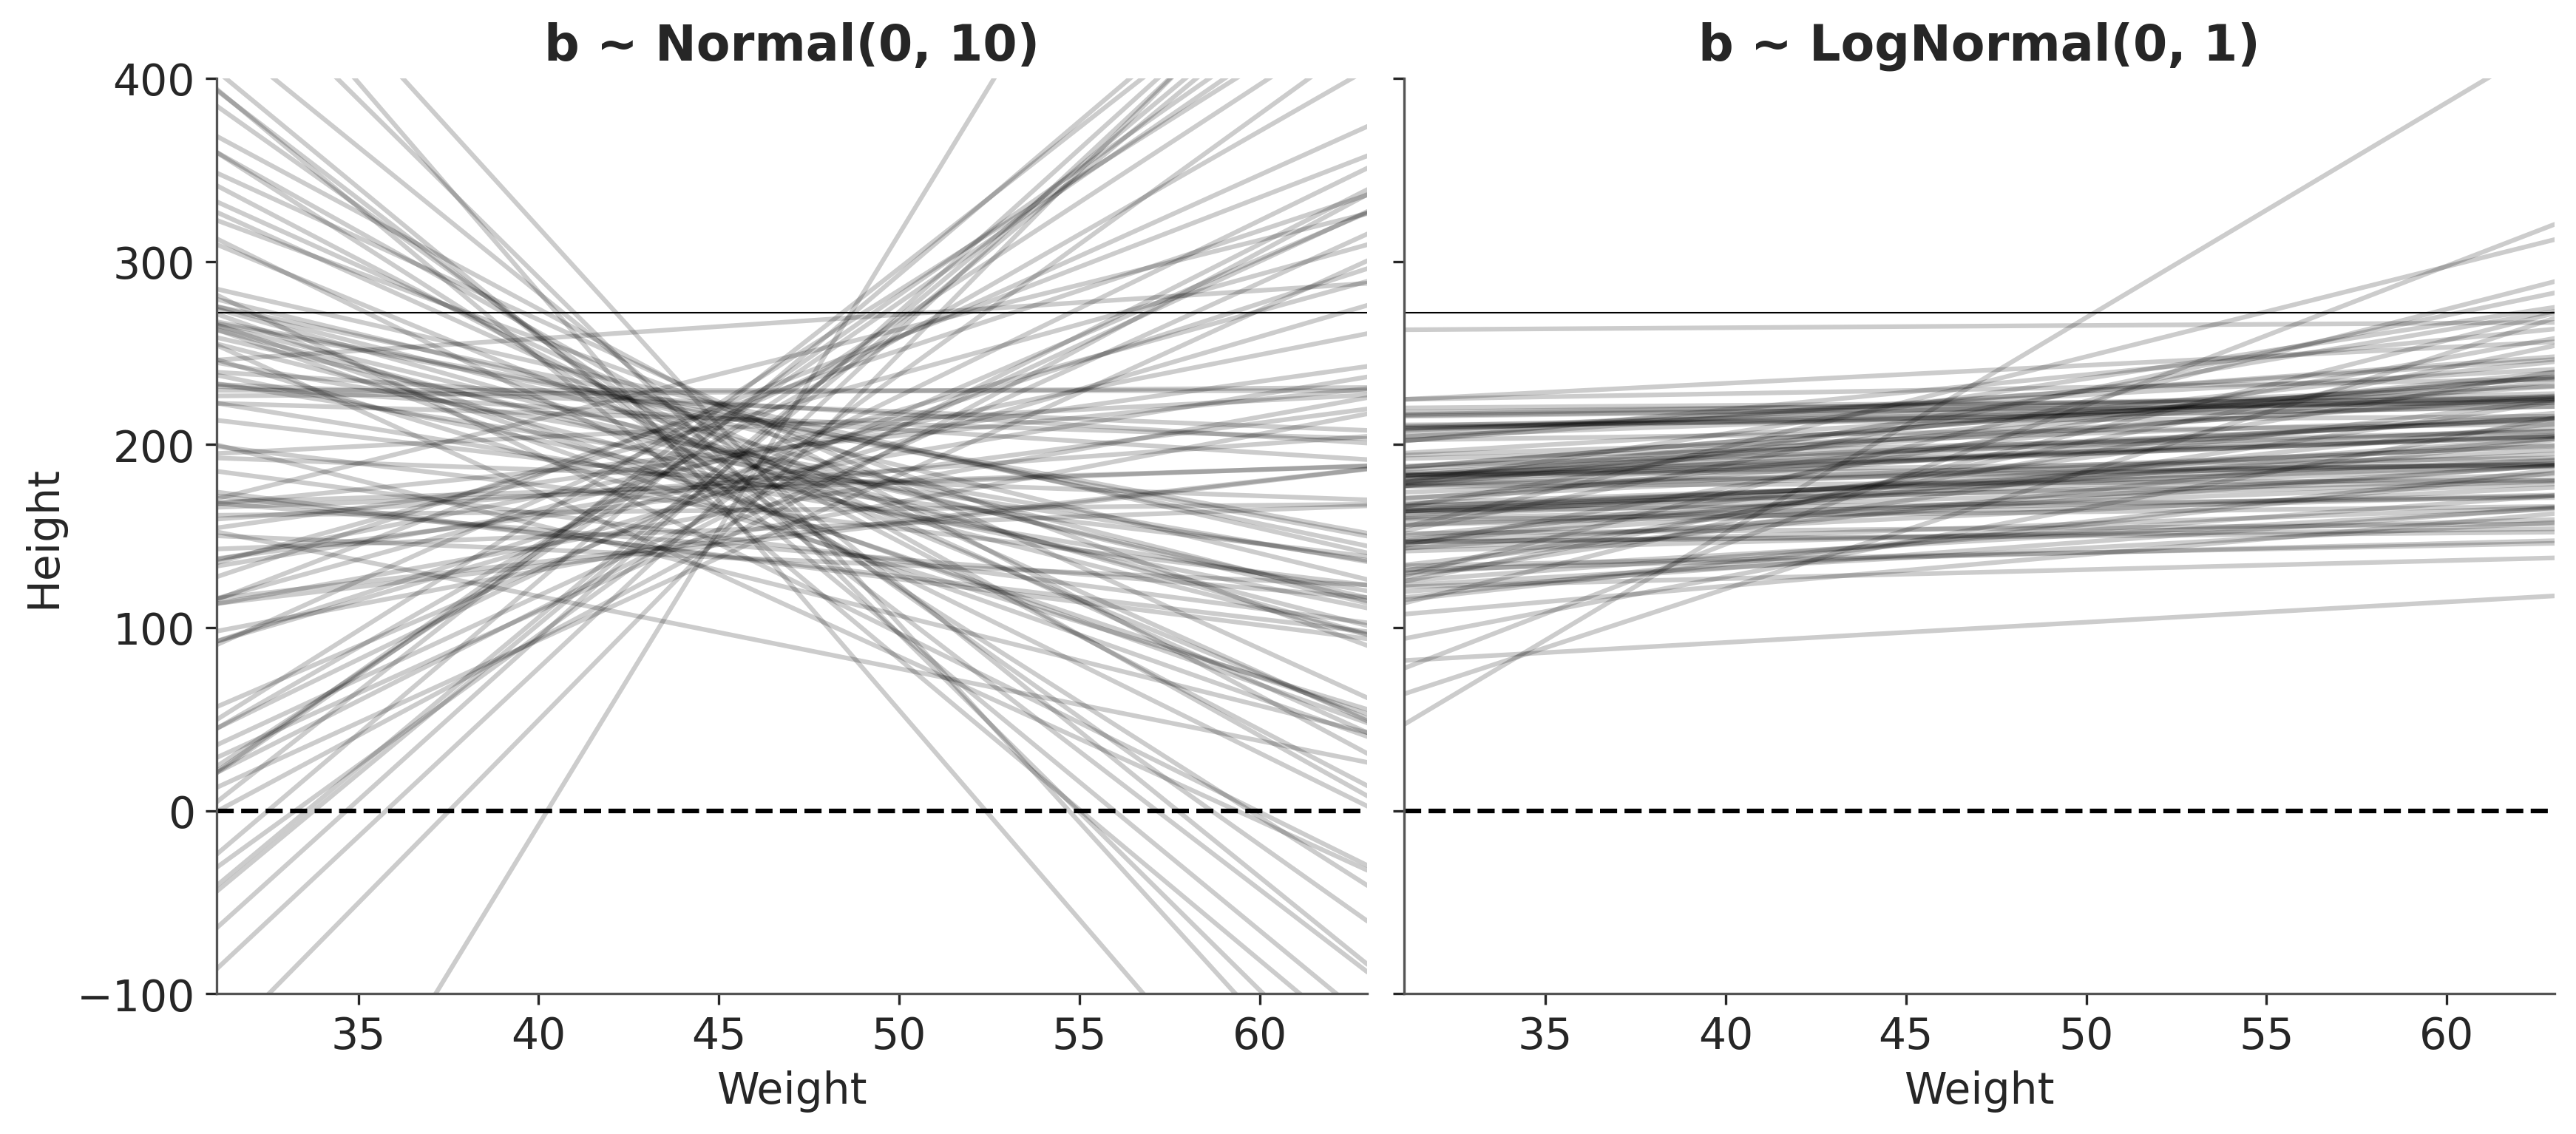

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].set(
    xlim=(df.weight.min(), df.weight.max()),
    ylim=(-100, 400),
    xlabel="Weight",
    ylabel="Height",
)
axes[1].set(xlabel="Weight")
axes[0].axhline(y=0, c="k", ls="--")
axes[0].axhline(y=272, c="k", ls="-", lw=0.5)
axes[1].axhline(y=0, c="k", ls="--")
axes[1].axhline(y=272, c="k", ls="-", lw=0.5)

axes[0].set_title("b ~ Normal(0, 10)")
axes[1].set_title("b ~ LogNormal(0, 1)")

weight_mean = df.weight.mean()
w = jnp.linspace(df.weight.min(), df.weight.max(), 101)
for i in range(N):
    axes[0].plot(w, alpha[i] + beta_vague[i] * (w - weight_mean), "k", alpha=0.2)
    axes[1].plot(w, alpha[i] + beta_tighter[i] * (w - weight_mean), "k", alpha=0.2)
plt.show()

The thin horizontal line (y=272) is the height of the tallest human being ever lived. The normal prior on the left can create a lot of unreasonable linear relationships between $W$ and $H$. On the contrary, the log normal distribution on the right is more realistic.

This process of checking the plausibility of priors using observed data is called **prior predictive check**.

### Step 4. Define the model
We can list priors, and relatioships between the parameters and observations:

$$
\begin{align}
H \sim \text{Normal}(\mu,\,\sigma) \\
\mu = \alpha + \beta(W - \bar{W}) \\
\alpha \sim \text{Normal}(178,\,20) \\
\beta \sim \text{Normal}(0,\,10) \\
\sigma \sim \text{Uniform}(0,\,50) 
\end{align}
$$

(For now, let's use the normal prior for $\beta$.)

In [23]:
weight_mean = df['weight'].mean()
df_slim = {
    "weight": jnp.array(df['weight'].values),
    "height": jnp.array(df['height'].values),
}

Note that we use `numpyro.deterministic` to track $\mu$ in the model.

In [24]:
def model0(weight, height=None):
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    alpha = numpyro.sample("alpha", dist.Normal(178, 20))
    beta = numpyro.sample("beta", dist.Normal(0, 10))
    mu = numpyro.deterministic("mu", alpha + beta * (weight - weight_mean))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Step 5. Compute the posterior
This time, we are going to use a sampling method, Markov chain Montel Carlo (MCMC). Here, we're using *Hamiltonian* Monte Carlo (HMC) method, No U-Turn Sampler (NUTS).

In [25]:
m0 = MCMC(NUTS(model0), num_warmup=500, num_samples=500, num_chains=4)
m0.run(random.PRNGKey(0), **df_slim)

/var/folders/p4/qlvc3drd5cg3r3sv_r04x8ch0000gn/T/ipykernel_32288/333879086.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  m0 = MCMC(NUTS(model0), num_warmup=500, num_samples=500, num_chains=4)
sample: 100%|█| 1000/1000 [00:01<00:00, 692.17it/s, 7 steps of size 8.69e-01. ac
sample: 100%|█| 1000/1000 [00:00<00:00, 7458.01it/s, 3 steps of size 9.33e-01. a
sample: 100%|█| 1000/1000 [00:00<00:00, 7437.37it/s, 7 steps of size 8.14e-01. a
sample: 100%|█| 1000/1000 [00:00<00:00, 7007.86it/s, 7 steps of size 7.46e-01. a


### Step 6. Check the computational results

In [26]:
m0.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    154.61      0.27    154.61    154.17    155.07   1943.32      1.00
      beta      0.90      0.04      0.90      0.84      0.98   2005.67      1.00
     sigma      5.10      0.20      5.09      4.79      5.41   1827.54      1.00

Number of divergences: 0


No divergence! What's a divergence?

#### Divergent transitions

MCMC sampler takes a step to estimate the posterior (basically a hyperplane). The figure below shows a schematic example. 

If the step size is too small (left), it's inefficient but if it's too big (right), our estimate can diverge from the true posterior (=true *trajectory*). This is called **divergent transition**.

![](../Images/mcmc.png)

If our posterior shape is non-smooth like below, divergent transition is more likely to occur.

In [27]:
Image(url="../Images/nonsmooth.png", width=300)

#### Model evaluation with cross-validation

Usually we use leave-one-out (LOO) CV to estimate the model performance. One downside is that to do this, we need to fit the model N times (N=number of samples). Instead, we can use **Pareto-smoothed importance sampling (PSIS)** and other metrics, which requires fitting the model only once.

PSIS allows us to compute **Expected log-predictive densities (ELPD)**, which essentially represents average **likelihood of predicting a data point given a model that's trained <u>without</u> that data point**:
$$Pr(y_{i}|y_{-i})$$

#### Pareto-k statistics

PSIS also returns an output called **k-stiatics** for *every observation* , which represents *influence of each observation*. 
- Low k value: the model can easily explain the observation.
- High k value: the model considers this as an unexpected observation.

**If our model has many observations with high k values, that means our model lacks explanatory power for our data (=the model doesn't explain the observation well).**

`arviz.loo` can automatically compute ELPD and summary of k-statistics.

In [28]:
az.loo(az.from_numpyro(m0))

Computed from 2000 posterior samples and 352 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1074.16    14.97
p_loo        3.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      352  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Step 7. Inspect/Utilize the posterior distribution

This shows the distribution of our parameter estimates based on the observed data.

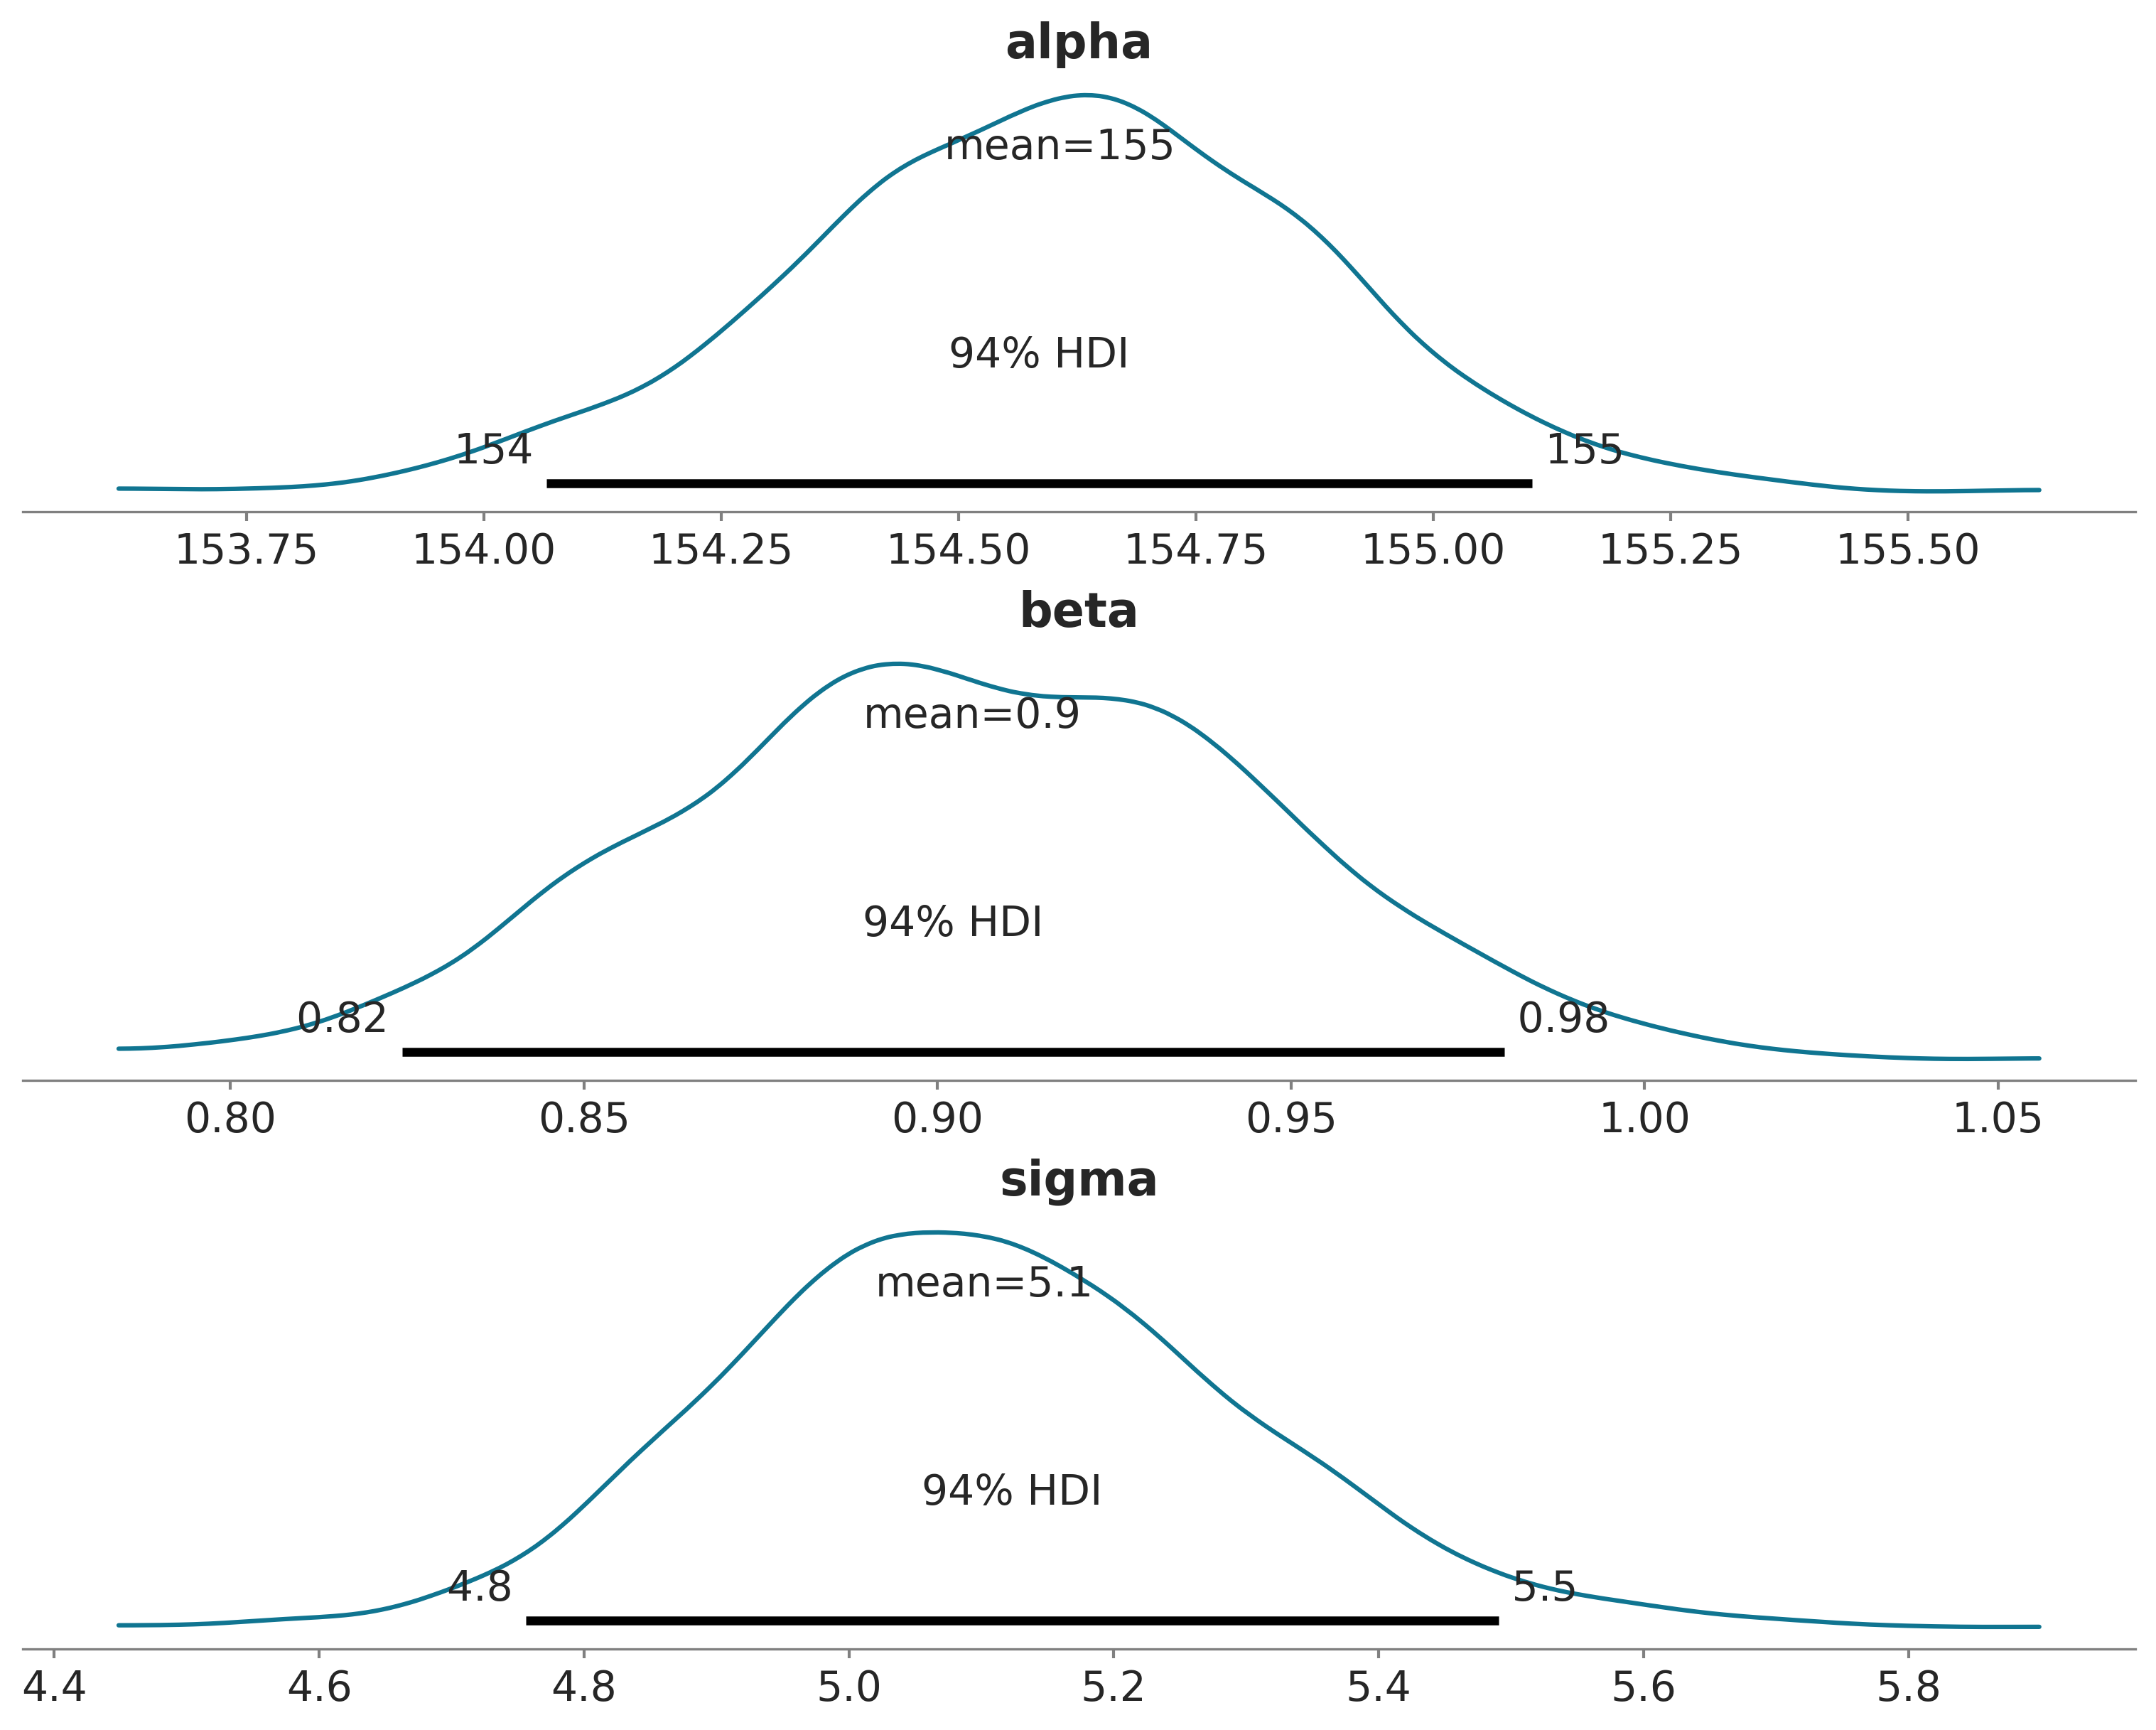

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
az.plot_posterior(az.from_numpyro(m0), var_names='alpha', ax=axes[0])
az.plot_posterior(az.from_numpyro(m0), var_names='beta', ax=axes[1])
az.plot_posterior(az.from_numpyro(m0), var_names='sigma', ax=axes[2])
plt.show()

#### Posterior predictive distribution 

MCMC has built a posterior distribution and now we can draw samples from this distribution. **We can plug these samples back to our model to get the predictions!**

In [30]:
post_samples = m0.get_samples()
print(post_samples)
print(post_samples['alpha'].shape)

{'alpha': Array([154.38168, 154.66925, 154.95532, ..., 154.63432, 155.13577,
       154.34549], dtype=float32), 'beta': Array([0.875026  , 0.93821007, 0.9038534 , ..., 0.86282736, 0.9583867 ,
       0.8431167 ], dtype=float32), 'mu': Array([[156.86249, 146.93987, 142.8964 , ..., 160.65788, 162.31993,
        160.98038],
       [157.3292 , 146.69008, 142.35463, ..., 161.39865, 163.1807 ,
        161.74442],
       [157.51785, 147.26834, 143.09166, ..., 161.4383 , 163.15509,
        161.77141],
       ...,
       [157.08054, 147.29625, 143.30916, ..., 160.82303, 162.4619 ,
        161.14102],
       [157.85292, 146.985  , 142.55632, ..., 162.00989, 163.83026,
        162.3631 ],
       [156.73582, 147.17505, 143.27904, ..., 160.39282, 161.99425,
        160.70355]], dtype=float32), 'sigma': Array([4.8822565, 5.1853733, 5.2756853, ..., 5.23175  , 5.1681633,
       5.1251497], dtype=float32)}
(2000,)


($\mu$ is calculated for every weight value and thus the dimension is different than other 3 parameters.)

#### 1. Sample the mean
We can use this formula to plot the linear relationship between the $W$ and $\mu$ (mean of height):
$$\mu = \alpha + \beta(W - \bar{W})$$

This one shows a single line based on the mean value:

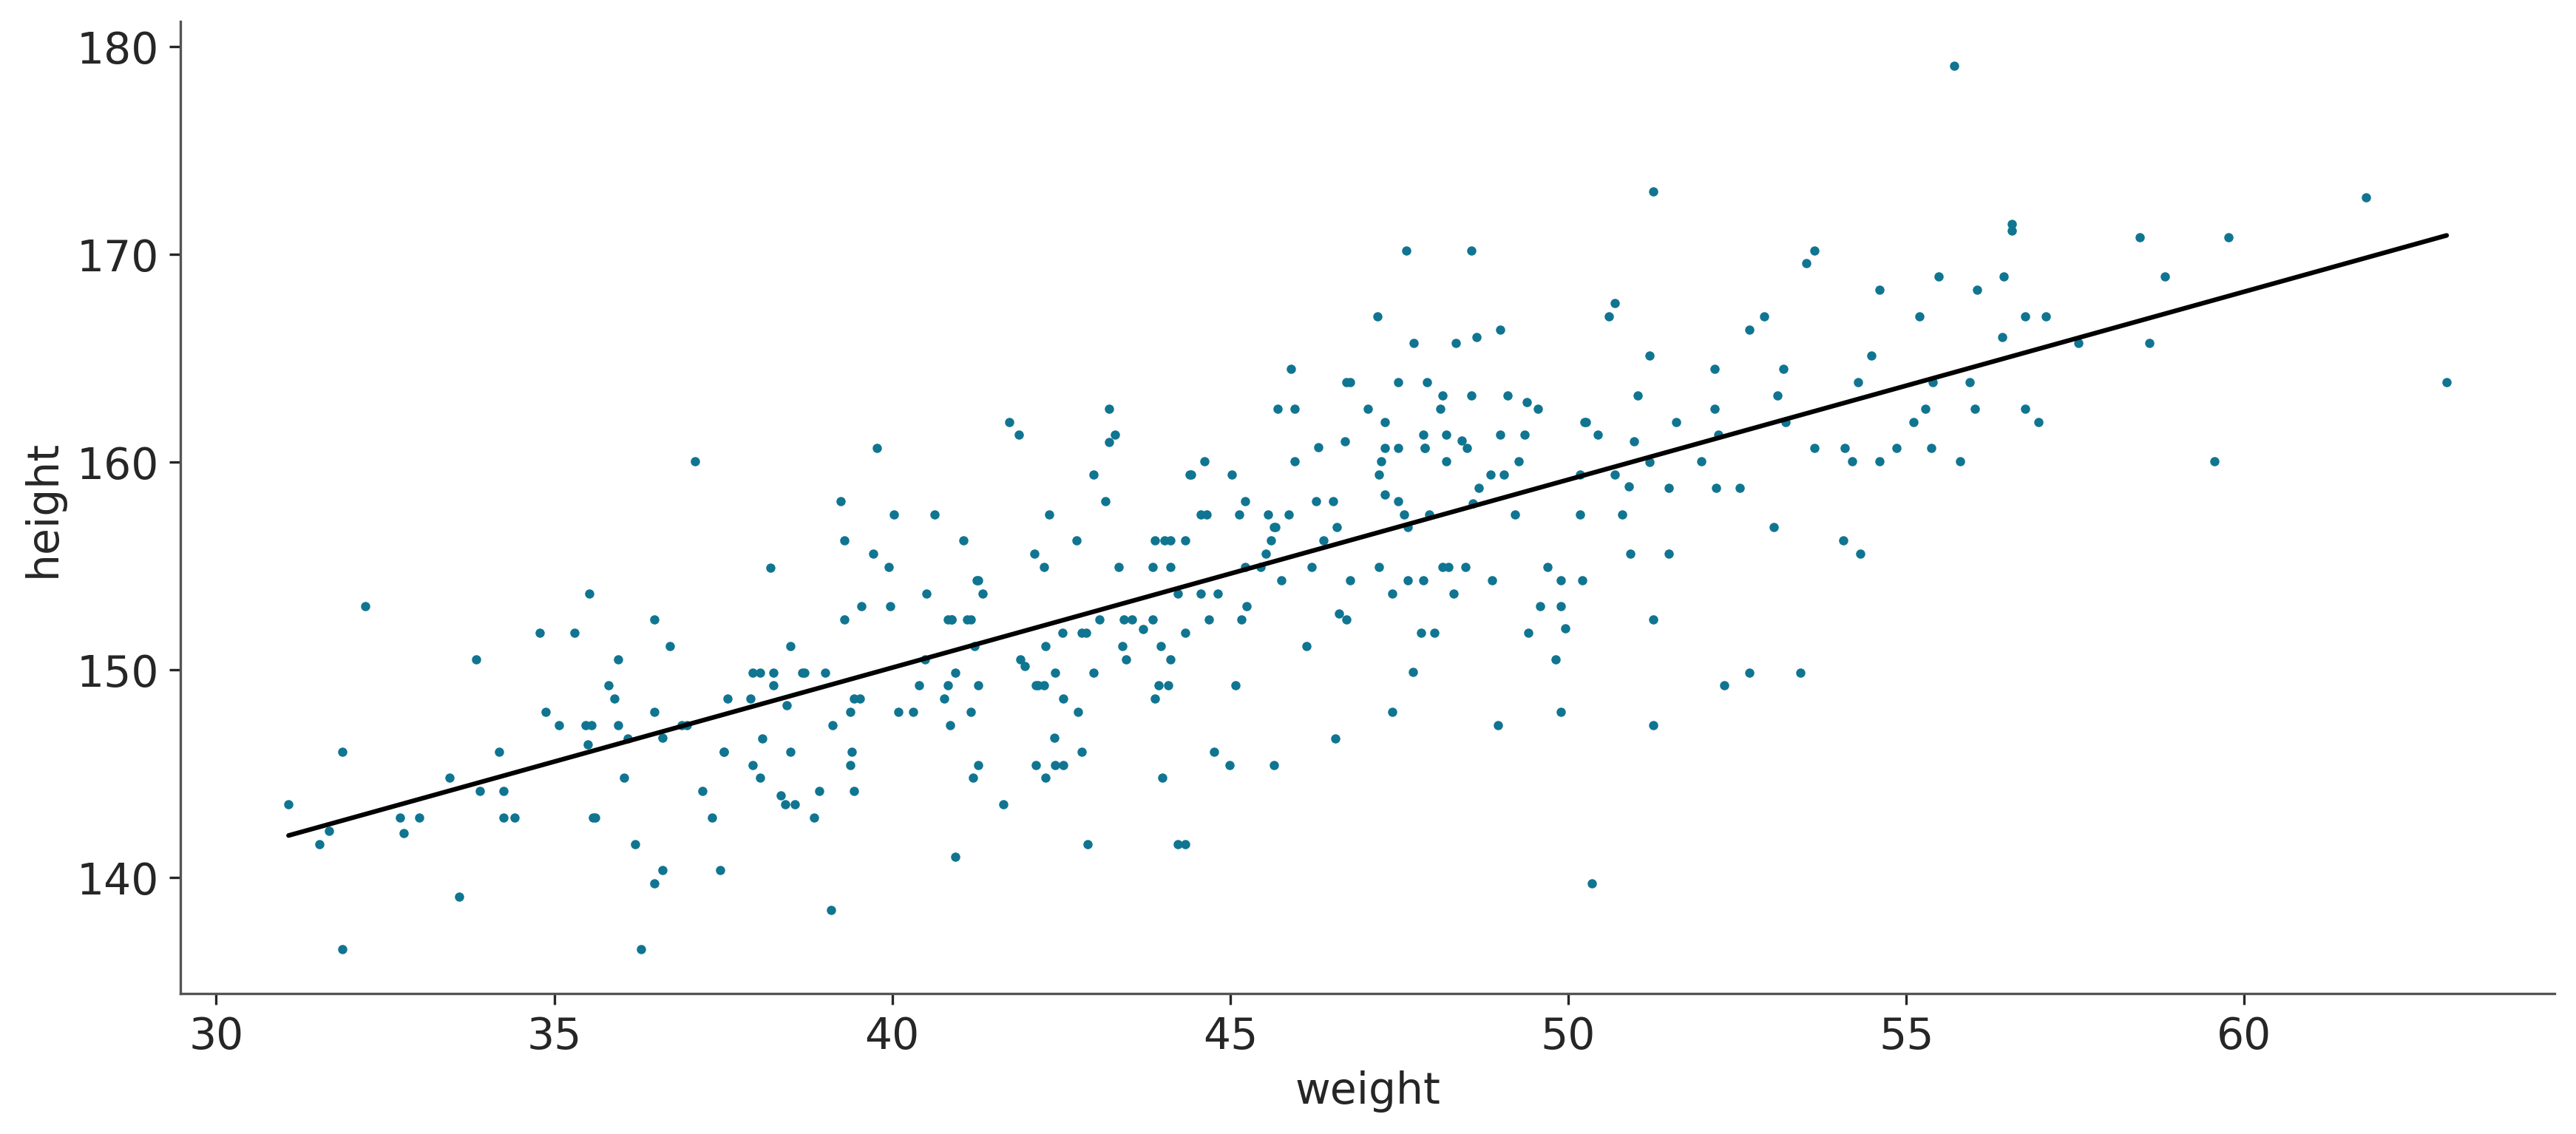

In [31]:
az.plot_pair(df_slim)
alpha_mean = jnp.mean(post_samples["alpha"])
beta_mean = jnp.mean(post_samples["beta"])
plt.plot(w, alpha_mean + beta_mean * (w - weight_mean), "k")
plt.show()

We can also plot individual samples:

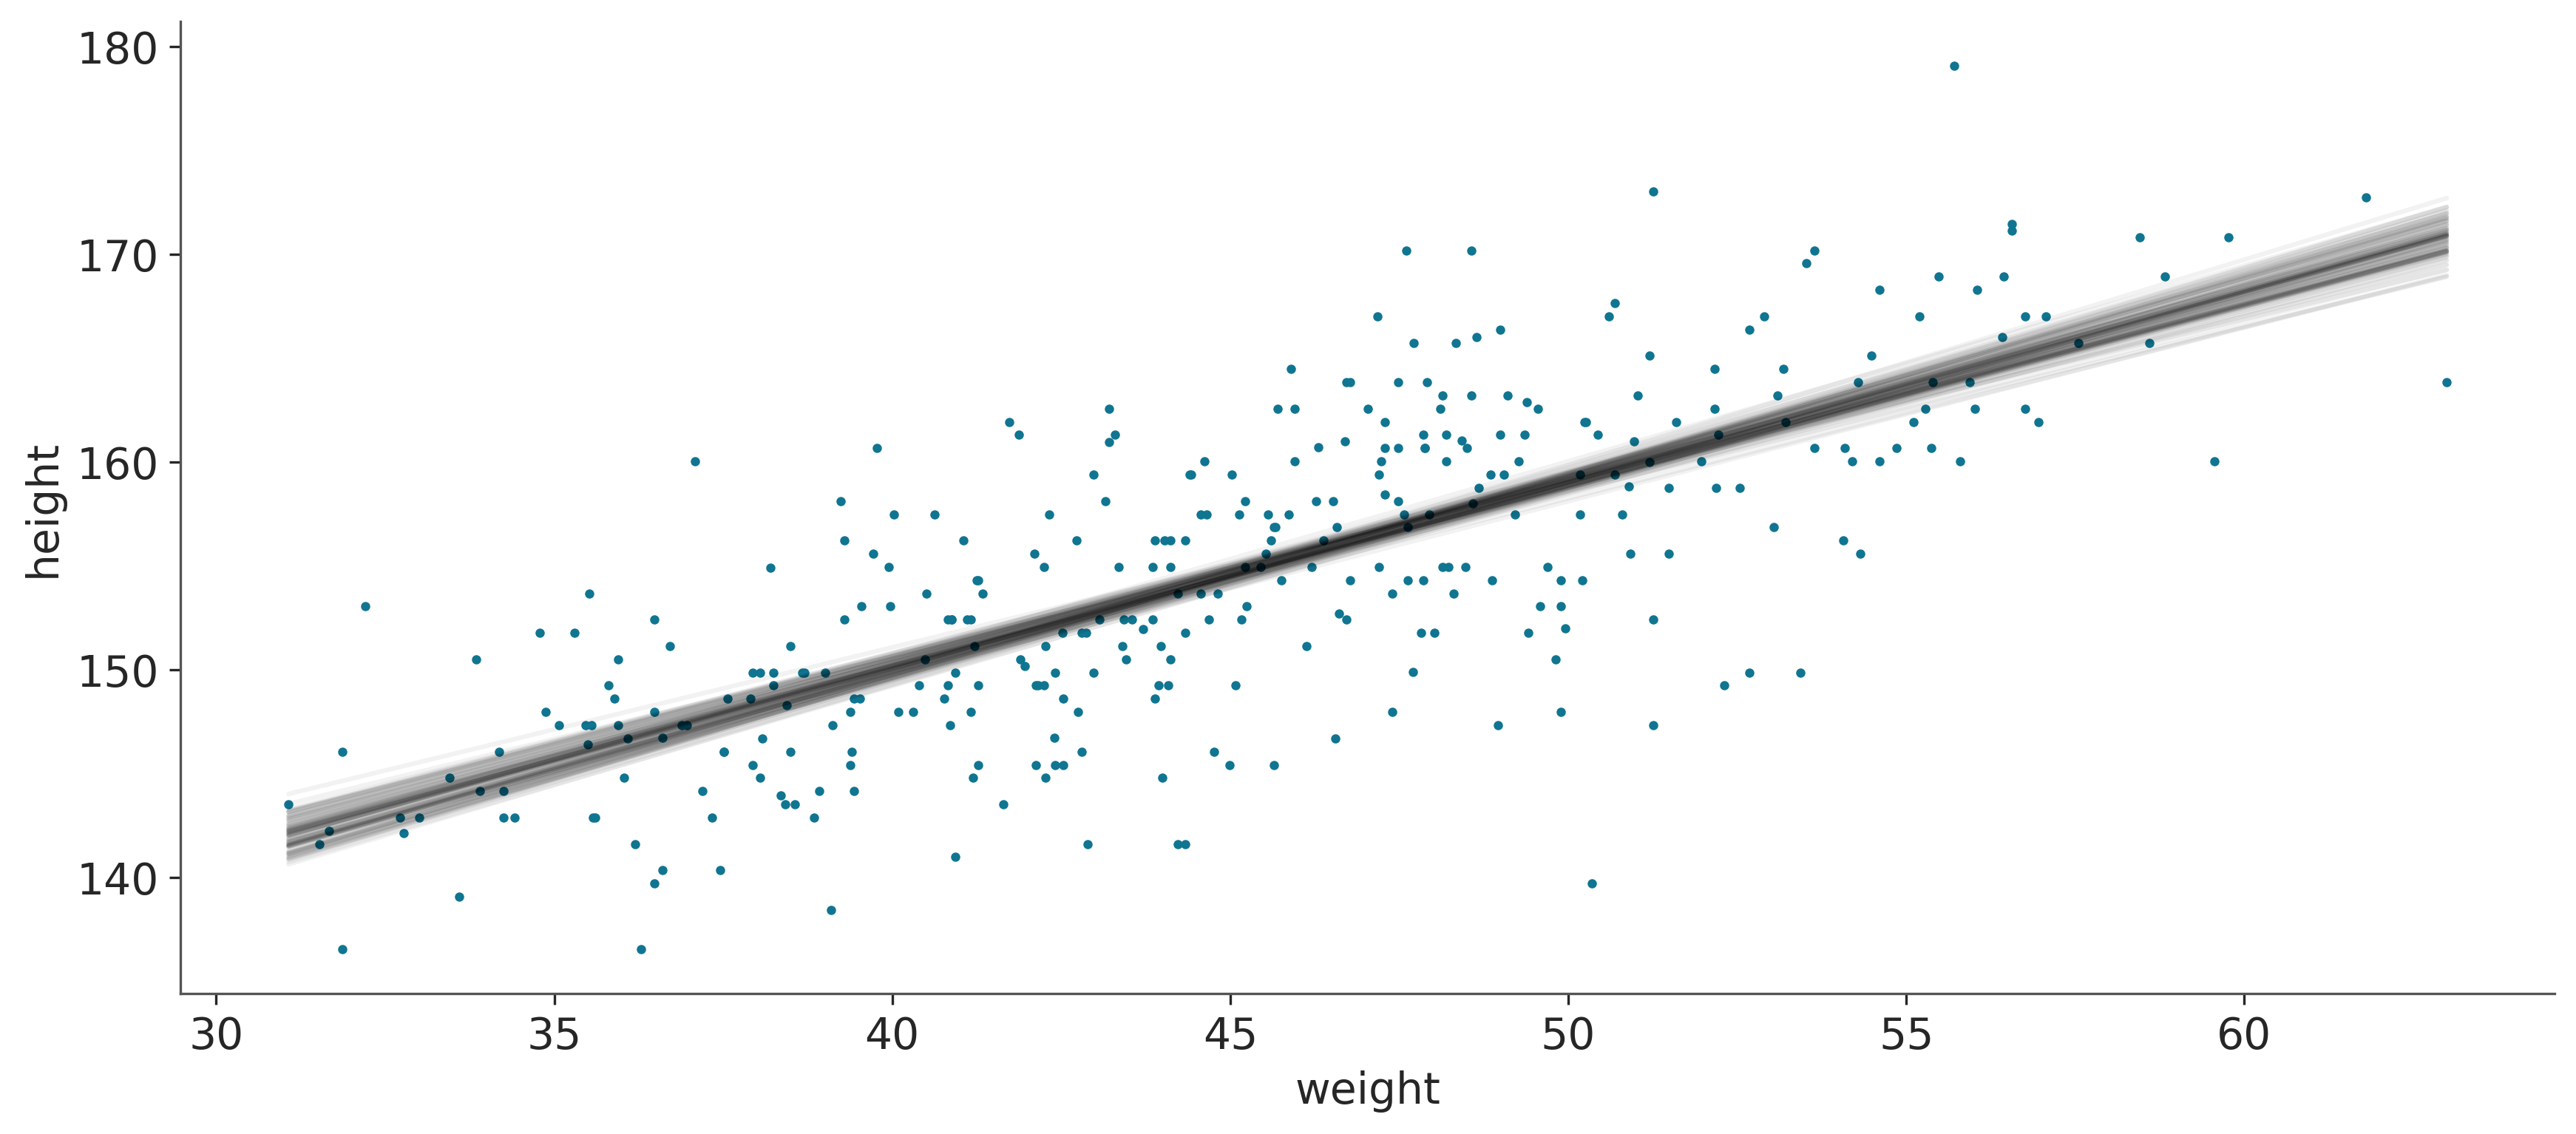

In [32]:
az.plot_pair(df_slim)
n_lines = 100
for i in range(n_lines):
    alpha_sample = post_samples['alpha'][i]
    beta_sample = post_samples['beta'][i]
    plt.plot(w, alpha_sample + beta_sample * (w - weight_mean), 'k', alpha=0.05)
plt.show()

By drawing the individual lines, we can **visualize the difference in model uncertainty** (more uncertain around the extreme values).

#### 2. Sample the height (target variable) = generate predictions
>At a given $W$, what values of $H$ the posterior samples produce?

In [33]:
n_grid_points = 100
hypothetical_weights = jnp.linspace(start=25, stop=71, num=n_grid_points)

This step allows us to plug our samples back to the model to genereate hypothetical heights.

In [34]:
predictive = Predictive(
    model=model0, 
    posterior_samples=post_samples, 
    return_sites=["height"]
)

sim_height = predictive(
    rng_key=random.PRNGKey(0),
    weight=hypothetical_weights)['height']

print(sim_height.shape)

(2000, 100)


This means, at a given weight value (100 in total), we generated 2000 prediction values using the posterior samples. But **what do we do with 2000 predictions of a given single input?**

#### 3. Visualize perecentile intervals

We can use a percental interval (in this example, middle 90%) to visualize the distribution of 2000 samples at a given input $W$ value.

In [35]:
sim_height_PI = jnp.percentile(sim_height, q=jnp.array([5, 95]), axis=0)
print(sim_height_PI.shape)

(2, 100)


(Note: it's an interval, so we get two values for each given $W$.)

We can compute this interval for $\mu$ as well.

In [36]:
mu_link = lambda w: post_samples["alpha"] + post_samples["beta"] * (w - weight_mean)
sim_mu = vmap(mu_link)(hypothetical_weights).T
sim_mu_mean = jnp.mean(sim_mu, 0)
sim_mu_PI = jnp.percentile(sim_mu, q=jnp.array([5, 95]), axis=0)
print(sim_mu_PI.shape)

(2, 100)


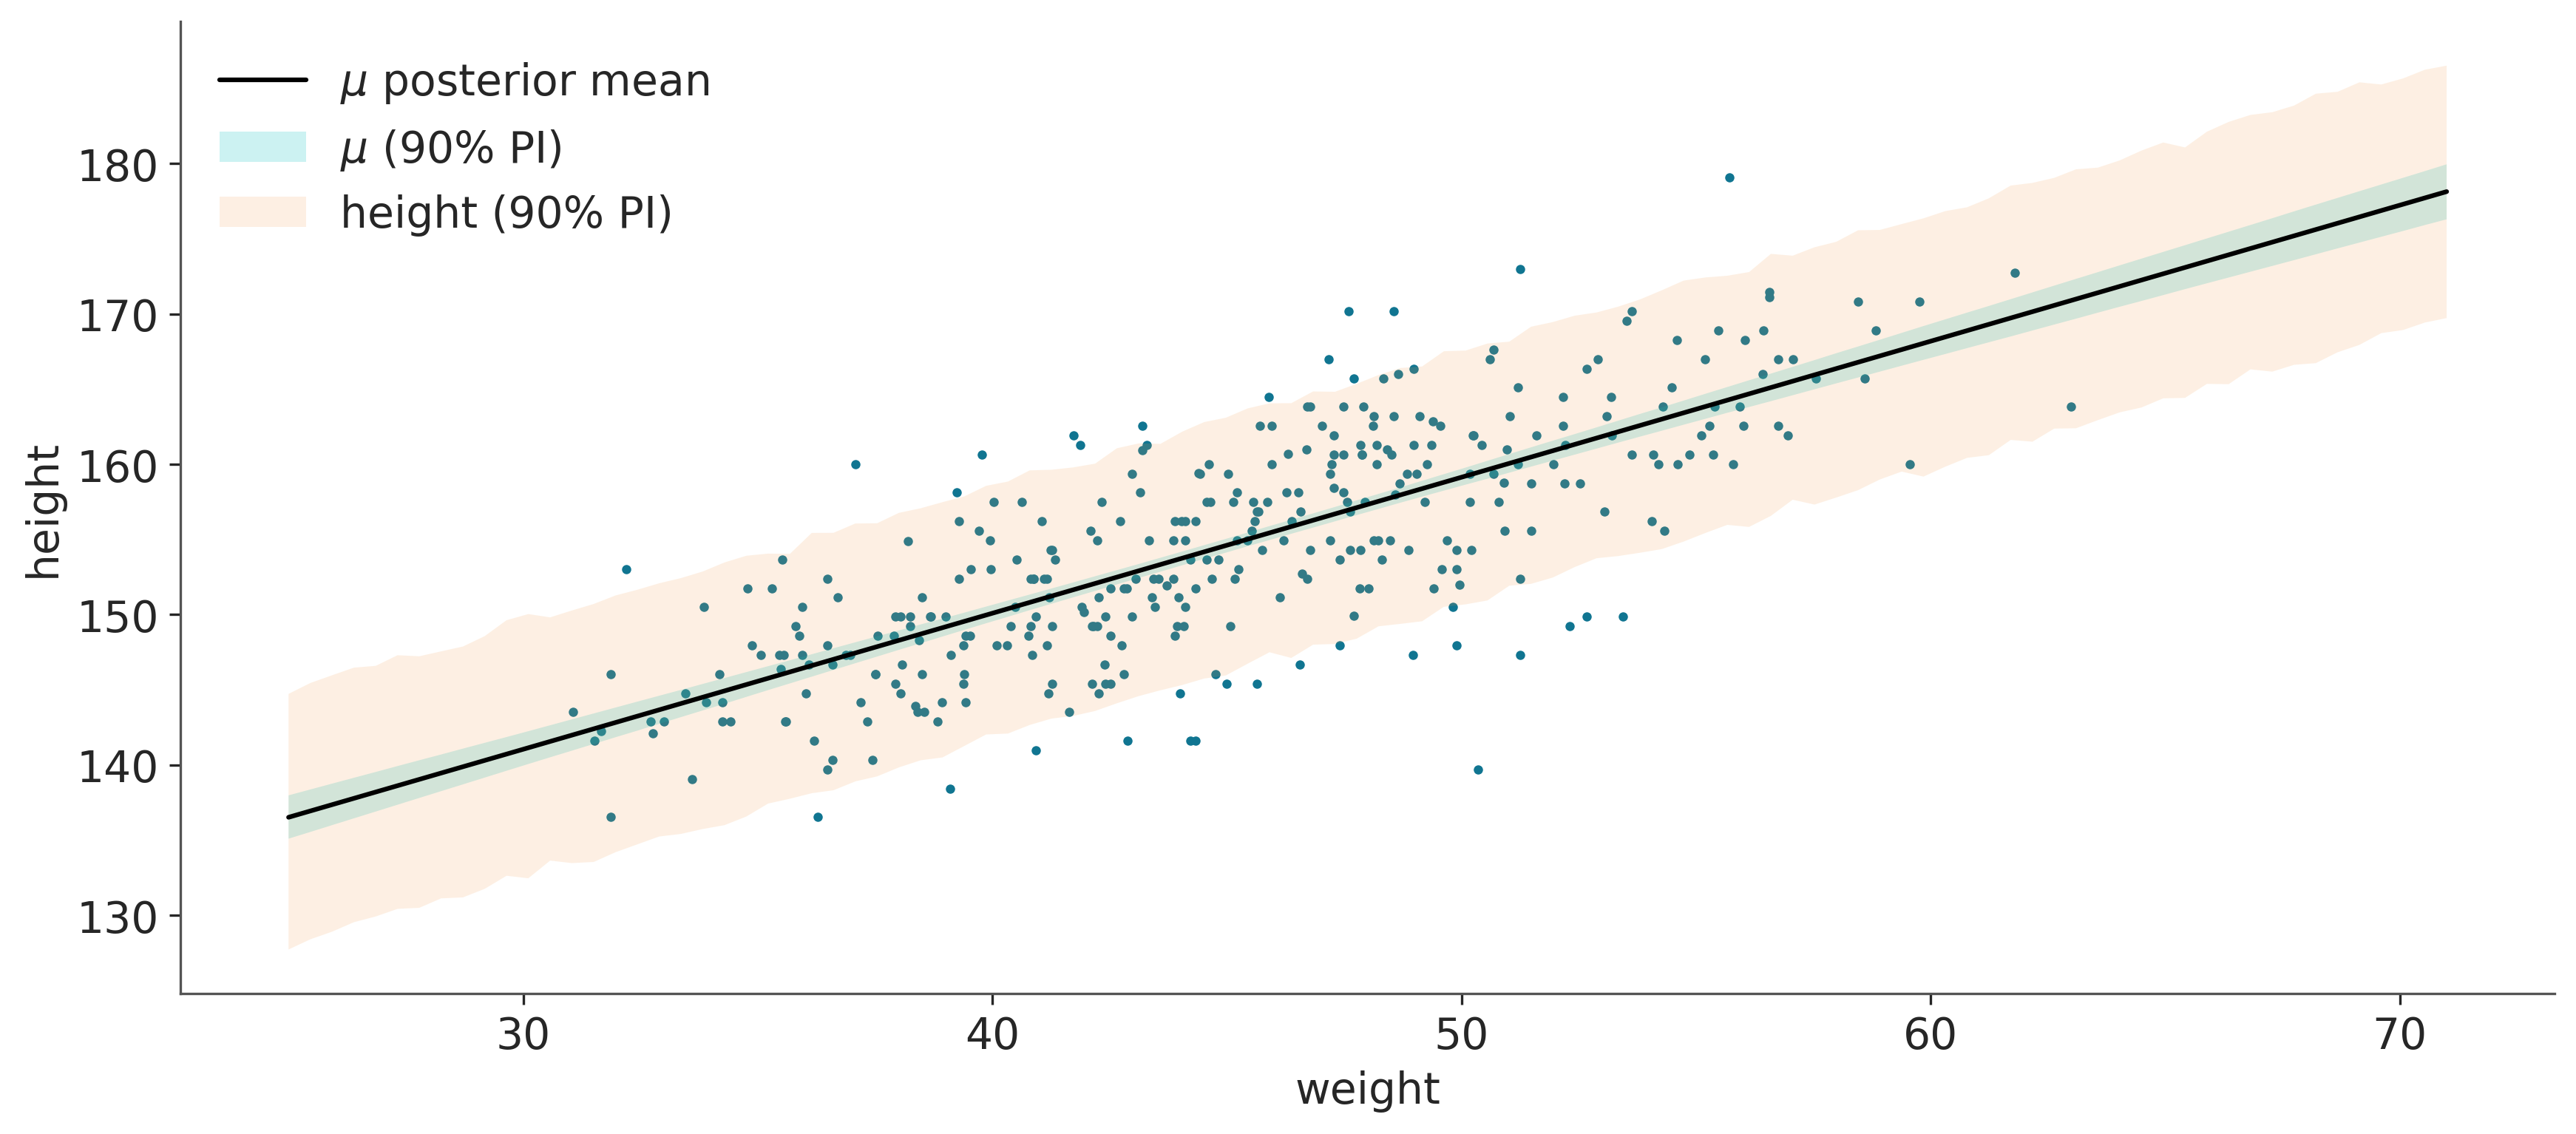

In [37]:
# plot raw data
az.plot_pair(df_slim)

# draw MAP line
plt.plot(hypothetical_weights, sim_mu_mean, "k", label='$\mu$ posterior mean')

# draw 90% PI for line
plt.fill_between(hypothetical_weights, sim_mu_PI[0], sim_mu_PI[1], alpha=0.2, label='$\mu$ (90% PI)')

# draw 90% PI for simulated heights
plt.fill_between(hypothetical_weights, sim_height_PI[0], sim_height_PI[1], alpha=0.15, label='height (90% PI)')
plt.legend()
plt.show()

This way, using a Bayesian model allows us to **generate prediction with uncertainty interval, not just a point estimate**.

## Air pollution data from the paper

In [38]:
df_air_pollution = pd.read_csv("../Data/air_pollution_pm2.5.csv")
cluster_region = pd.read_csv("../Data/air_pollution_pm2.5_cluster.csv")
df_air_pollution['cluster_region'] = cluster_region
df_air_pollution.head()

City_locality iso3    country  super_region super_region_name       pm25  \
0           NaN  AUS  Australia             1        HighIncome  33.463801   
1  ´è_´è__lhavo  PRT   Portugal             1        HighIncome  15.000000   
2   ´è_´è__vila  ESP      Spain             1        HighIncome  10.000000   
3        AACHEN  DEU    Germany             1        HighIncome  13.000000   
4       AALBORG  DNK    Denmark             1        HighIncome  11.000000   

    sat_2014  cluster_region  
0  33.314292               2  
1   9.867000               2  
2   9.175500               2  
3  15.537997               2  
4   9.798502               2

In [39]:
df_air_pollution['super_region'].value_counts().sort_index()

1    1911
2     159
3     140
4     362
5     103
6     266
7      39
Name: super_region, dtype: int64

In [40]:
df_air_pollution['cluster_region'].value_counts().sort_index()

1      14
2    2172
3     400
4     376
5      10
6       8
Name: cluster_region, dtype: int64

In [41]:
air_pollution_log = {
    '$log(satellite)$': jnp.log(df_air_pollution['sat_2014'].values),
    '$log(PM_{2.5})$': jnp.log(df_air_pollution['pm25'].values),    
}

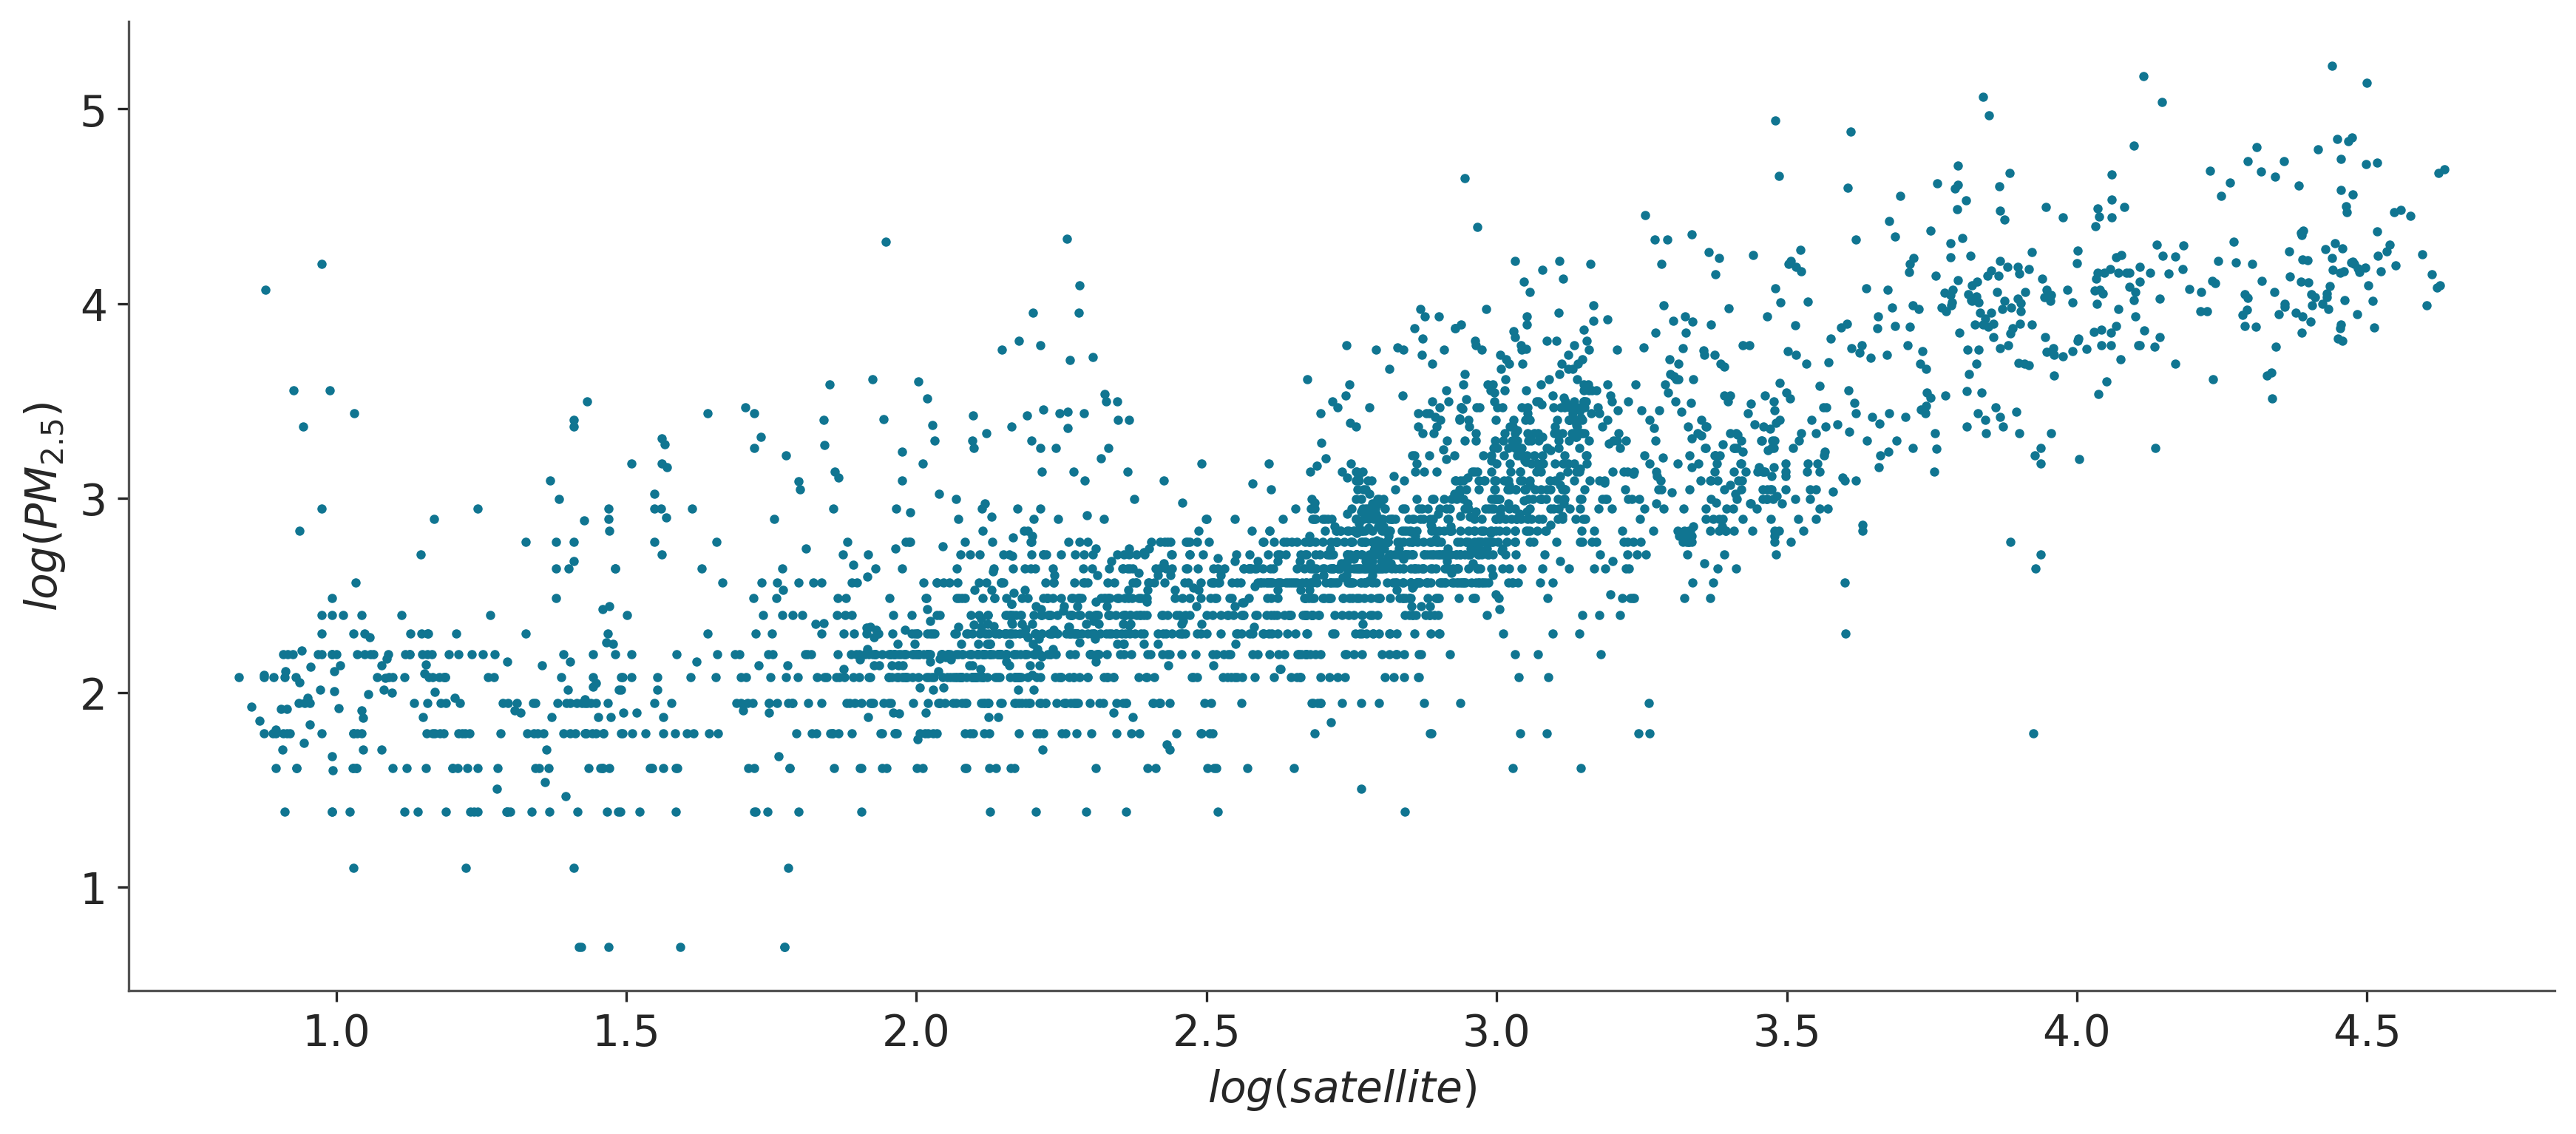

In [42]:
az.plot_pair(air_pollution_log)
plt.show()